# Analyze sessions in batch from Phase 1 of AdaDrive (work in progress)

In [41]:
import sys
 
# setting path
sys.path.append('..')

from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle, os
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display

import matplotlib.pyplot as plt
from mna.sessions.eye_session import process_session_eye
from mna.sessions.eeg_session import process_session_eeg
from mna.sessions.motor_session import process_session_motor
from mna.sessions.ecg_session import process_session_ecg
from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data
import pickle
from statannotations.Annotator import Annotator
from collections import defaultdict
from scipy import stats

# 1. Read a RN App, converted pkl file, and create the metadata and data structure

In [3]:
import matplotlib
matplotlib.use('Agg')

# Batch convert raw files into pickle

In [4]:
from mna.utils.rnapp_data_format import read_all_files

In [5]:
#read_all_files(data_dir='/home/jupyter/raw_data/',
#               pickle_dir='/home/jupyter/mna/data/', save_pickle=True)

# Batch analysis

In [6]:
data_dir = "../data/"
lsl_dir = "../mna/LSLPresets/"
output_dir = '../output/batch_analysis/'
if not os.path.isdir(output_dir): os.makedirs(output_dir)
metadata_jsons = read_all_lslpresets(path_to_jsonfiles=lsl_dir)
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.pkl' in f]

save_data_pkl = False # save data into pickle files
save_ica_plts = False # save ICA components plots
rs = 64 # random seed

In [ ]:
all_dfs = None
motor_events = True
# ica_epochs_dict = {}
# fddica_dict = {}
# eog_idx_dict = {}
# events_dict = {}

for each_file in onlyfiles:
    print('current file', each_file)
    input_path = data_dir + each_file
    
    sbj_id = each_file[each_file.find('Sbj_')+4:each_file.find('-Ssn')]
    ssn_no = each_file[each_file.find('Ssn_')+4:each_file.find('.dats')]

    if len(sbj_id) < 2: sbj = "sbj0"+sbj_id
    else: sbj = "sbj"+sbj_id
    if len(ssn_no) < 2: ssn = "ssn0"+ssn_no
    else: ssn = "ssn"+ssn_no
    
    with open(input_path, 'rb') as handle:
        rns_data = pickle.load(handle)

    ## Add metadata to data

    for key in rns_data.keys():
        rns_data[key].append(return_metadata_from_name(key, metadata_jsons))

    event_df = event_data_from_data(rns_data, interrupted_id_sessions=[(13,1), (22,1)])
    event_df['trial_damage'] = event_df.damage.diff().fillna(0)
    event_df['trial_duration'] = event_df.trial_end_time - event_df.trial_start_time
    percent_missing = event_df.notnull().sum() / len(event_df)
    summary_statistics = {}
    summary_statistics['voice_success_rate'] = percent_missing['voice_timestamp']
    if 'chunk_timestamp' in percent_missing:
        summary_statistics['chunk_success_rate'] = percent_missing['chunk_timestamp']
    else:
        summary_statistics['chunk_success_rate'] = 0

    # temporary fix for pilot phase where we had some incomplete data
    if 'block_condition' not in event_df:
        event_df['block_condition'] = 'practice'
        event_df.loc[5:,'block_condition'] = 'voice'

    event_df['spoken_difficulty_encoded'] = event_df.spoken_difficulty.replace(to_replace=['easy', 'hard', 'unknown'],
                                                                          value=[1, 2, None])
    # motor
    post_processed_event_df, turns_df = process_session_motor(rns_data, event_df, motor_channel='Unity_MotorInput',
                                                plot_motor_result = True, plot_motor_snippet = 30, plot_frequency = 10)

    if motor_events:
        post_processed_event_df = turns_df
    
    # ecg
    try:
        post_processed_event_df = process_session_ecg(rns_data, post_processed_event_df,plot_frequency=20,plot_ecg_snippet=40)
    except:
        pass
    
    # eye
    if 'Unity_ViveSREyeTracking' in rns_data:
        post_processed_event_df = process_session_eye(rns_data, post_processed_event_df,pretrial_period=60,
                                                      detect_blink=True,plot_frequency=20,posttrial_period=0,
                                                      plot_eye_snippet=40, classifiers=['NSLR'])
    try:
        # eeg
        post_processed_event_df, epochs, events, info, reject_log, ica, eog_idx= process_session_eeg(rns_data, post_processed_event_df,
                                                                        event_column='spoken_difficulty_encoded', run_autoreject=True, run_ica=False,
                                                                        raw_eeg_fname = sbj+ssn+"eeg_filt_raw", save_raw_eeg = False, template_ica = None)
    except:
        pass

    # save
    
    if motor_events:
        post_processed_event_df.to_csv(f"{output_dir}ppid_{post_processed_event_df.iloc[0].ppid}_session_{post_processed_event_df.iloc[0].session}_motor.csv")
    else:
        post_processed_event_df.to_csv(f"{output_dir}ppid_{post_processed_event_df.iloc[0].ppid}_session_{post_processed_event_df.iloc[0].session}.csv")
    if not type(all_dfs)==pd.core.frame.DataFrame:
        all_dfs = post_processed_event_df
    else:
        all_dfs = pd.concat([all_dfs, post_processed_event_df], ignore_index=True)
    

current file 09_14_2022_13_17_39-Exp_adadrive-Sbj_20-Ssn_3.dats.pkl


# Save results and generate interactive PivotTable

In [ ]:
from pivottablejs import pivot_ui
if motor_events:
    all_dfs.to_csv(f"{output_dir}all_results_motor.csv", index=False)
    all_dfs.to_excel(f"{output_dir}all_results_motor.xlsx")
    pivot_ui(all_dfs, outfile_path=f"{output_dir}all_results_motor.html");
else:
    all_dfs.to_csv(f"{output_dir}all_results.csv", index=False)
    all_dfs.to_excel(f"{output_dir}all_results.xlsx")
    pivot_ui(all_dfs, outfile_path=f"{output_dir}all_results.html");

# 11-07-22 Meeting

In [7]:
trial_dfs = pd.read_excel(f"{output_dir}all_results_trial.xlsx")
motor_dfs = pd.read_excel(f"{output_dir}all_results_motor.xlsx")

In [8]:
# seaborn
sns.set(font_scale=1.2)
sns.set_palette("tab10")
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials

cols_of_interest = ["bpm", "density", "trial_duration", "trial_damage",
                                         "abs_sum_delta_steer_input", "abs_sum_delta_brake_input",
                                         "NSLR_count_Fixation", "NSLR_count_Saccade"]
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['spoken_difficulty','Left Pupil Diameter', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation','NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['spoken_difficulty','density','bpm','sdnn', 'rmssd','pnn50'] # rmssd = parasympathetic
motor_cols = ['spoken_difficulty','density','abs_sum_delta_steer_input','abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input'] 

def clean_up_trials(input_df):
    all_dfs_final = clean_up_adadrive_trials(input_df.copy())
    # damage change
    all_dfs_final = all_dfs_final.sort_values(by=['ppid', 'session', 'block'])
    # nan, outliers
    for col in cols_of_interest:
        all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
    all_dfs_final['abs_sum_delta_brake_input'] = all_dfs_final['abs_sum_delta_brake_input'].mask(all_dfs_final['abs_sum_delta_brake_input']>.1)

    all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation']-all_dfs_final['trial_start_time']
    all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade']-all_dfs_final['trial_start_time']
    all_dfs_final['bpm'] = all_dfs_final['bpm'].mask((all_dfs_final['bpm']<40) | (all_dfs_final['bpm']>150))
    all_dfs_final['throttle_over_brake'] = all_dfs_final.abs_sum_delta_throttle_input/all_dfs_final.abs_sum_delta_brake_input
    return all_dfs_final

motor_dfs = clean_up_trials(motor_dfs)
trial_dfs = clean_up_trials(trial_dfs)

# pupil bins
motor_dfs['pupil_bin'] = motor_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
                     lambda x: pd.qcut(x, 2, labels=['low','high']))
trial_dfs['pupil_bin'] = trial_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
                     lambda x: pd.qcut(x, 2, labels=['low','high']))

easy vs. hard: Custom statistical test, P_val:1.414e-16
easy vs. hard: Custom statistical test, P_val:5.488e-01
low vs. high: Custom statistical test, P_val:5.282e-01
low vs. high: Custom statistical test, P_val:7.346e-02


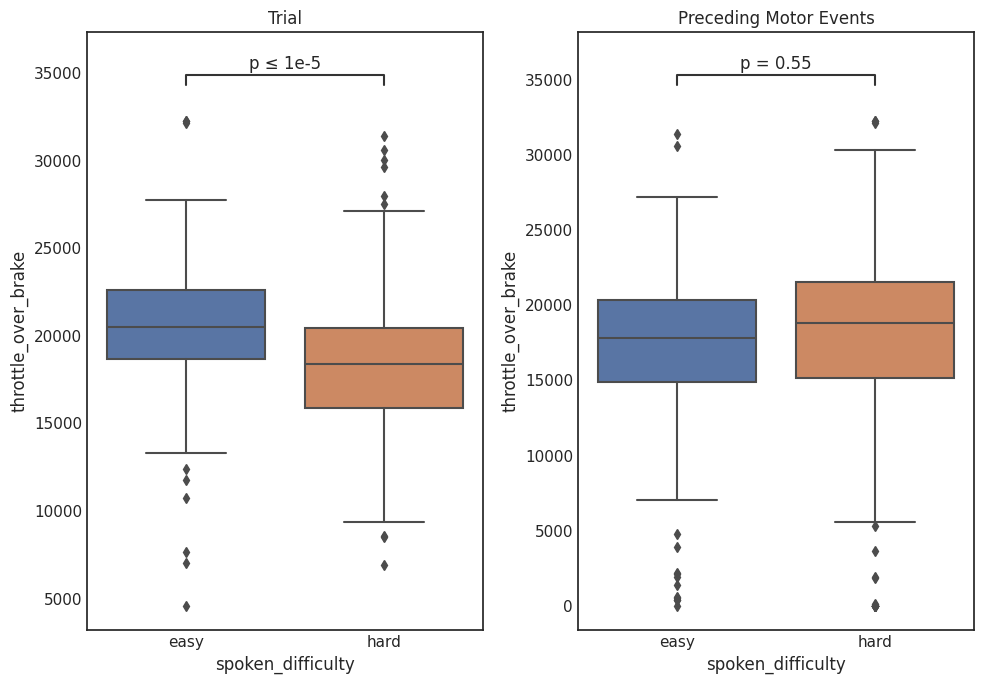

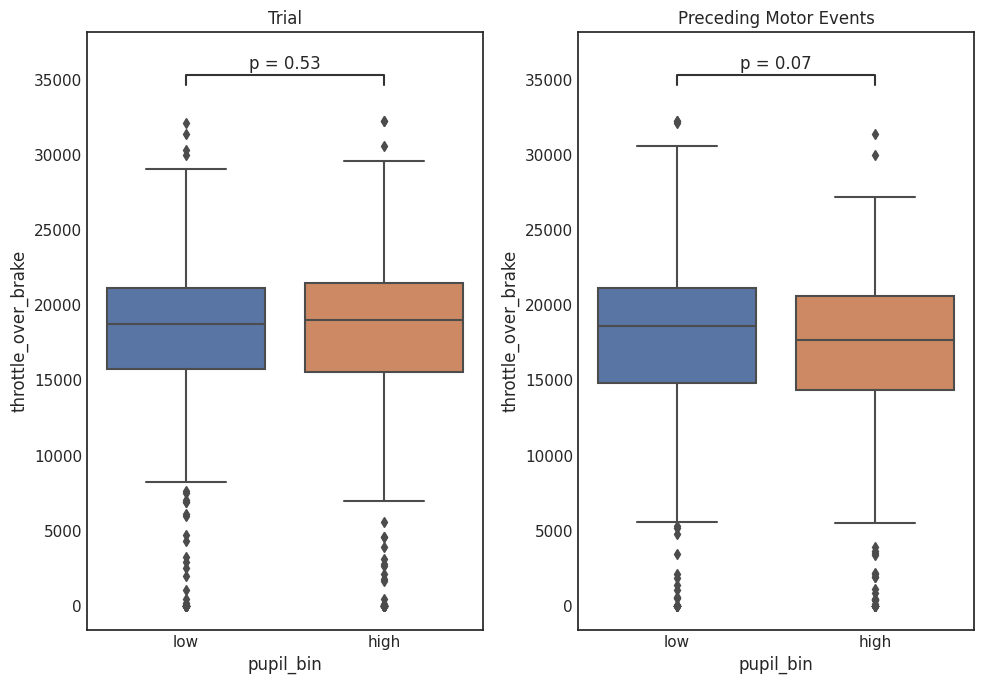

In [99]:
%matplotlib inline

sns.set(font_scale=1)
plt.style.use('seaborn-white')

def compare_motor_trial(trial_dfs, motor_dfs, y, x, order=None, ylabel=None, xlabel=None):
    ax1_plotting_parameters = {
        'data':    trial_dfs,
        'x':       x,
        'y':       y,
        'order': order
    }
    ax2_plotting_parameters = {
        'data':    motor_dfs,
        'x':       x,
        'y':       y,
        'order': order
    }
    stat_results = defaultdict(list)
    formatted_pvalues = defaultdict(list)
    for idx,o in enumerate(order[1:]):
        relevant_axis = ax1_plotting_parameters
        this_df = relevant_axis['data']
        this_x = relevant_axis['x']
        this_y = relevant_axis['y']
        ax1_low = this_df.loc[(this_df[this_x] ==  order[idx-1]),  this_y].dropna().values
        ax1_high = this_df.loc[(this_df[this_x] ==  order[idx]),  this_y].dropna().values
        relevant_axis = ax2_plotting_parameters
        this_df = relevant_axis['data']
        this_x = relevant_axis['x']
        this_y = relevant_axis['y']
        ax2_low = this_df.loc[(this_df[this_x] ==  order[idx-1]),  this_y].dropna().values
        ax2_high = this_df.loc[(this_df[this_x] ==  order[idx]),  this_y].dropna().values
        stat_results['ax1'].append(stats.ttest_ind(ax1_low, ax1_high, alternative="two-sided").pvalue)
        stat_results['ax2'].append(stats.ttest_ind(ax2_low, ax2_high, alternative="two-sided").pvalue)
    formatted_pvalues['ax1'] = [f'p={pvalue:.2e}' for pvalue in stat_results['ax1']]
    formatted_pvalues['ax2'] = [f'p={pvalue:.2e}' for pvalue in stat_results['ax2']]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(**ax1_plotting_parameters, ax=ax1)
    sns.boxplot(**ax2_plotting_parameters, ax=ax2)
    ax1.set_title("Trial")
    ax2.set_title("Preceding Motor Events")
    
    # add stats
    annotator = Annotator(ax1, [(order[0],order[1])], **ax1_plotting_parameters)
    #annotator.set_custom_annotations(formatted_pvalues['ax1'])
    #annotator.annotate()
    annotator.configure(text_format="simple")
    annotator.set_pvalues_and_annotate(stat_results['ax1'])
    
    
    annotator = Annotator(ax2, [(order[0],order[1])], **ax2_plotting_parameters)
    #annotator.set_custom_annotations(formatted_pvalues['ax2'])
    #annotator.annotate()
    annotator.configure(text_format="simple")
    annotator.set_pvalues_and_annotate(stat_results['ax2'])

    fig.tight_layout()
    
    #g = sns.distplot(data=trial_dfs, y=y, x=x, kind="box", order=['easy','hard'], aspect=2)
    #g.set_axis_labels(f"{xlabel if xlabel else x}", f"{ylabel if ylabel else y}")
    #g.fig.suptitle('Trial', fontsize=20)
    
    #g = sns.distplot(data=motor_dfs, y=y, x=x, kind="box", order=['easy','hard'], aspect=2)
    #g.set_axis_labels(f"{xlabel if xlabel else x}", f"{ylabel if ylabel else y}")
    #g.fig.suptitle('Preceding Motor Events', fontsize=20)
    

compare_motor_trial(trial_dfs, motor_dfs, y='throttle_over_brake', x='spoken_difficulty', ylabel='Perceived difficulty', order=['easy','hard'])
compare_motor_trial(trial_dfs, motor_dfs, y='throttle_over_brake', x='pupil_bin', order=['low','high'])

## Eye tracking 

easy vs. hard: Custom statistical test, P_val:2.097e-01
easy vs. hard: Custom statistical test, P_val:5.086e-01
low vs. high: Custom statistical test, P_val:3.168e-01
low vs. high: Custom statistical test, P_val:5.705e-01


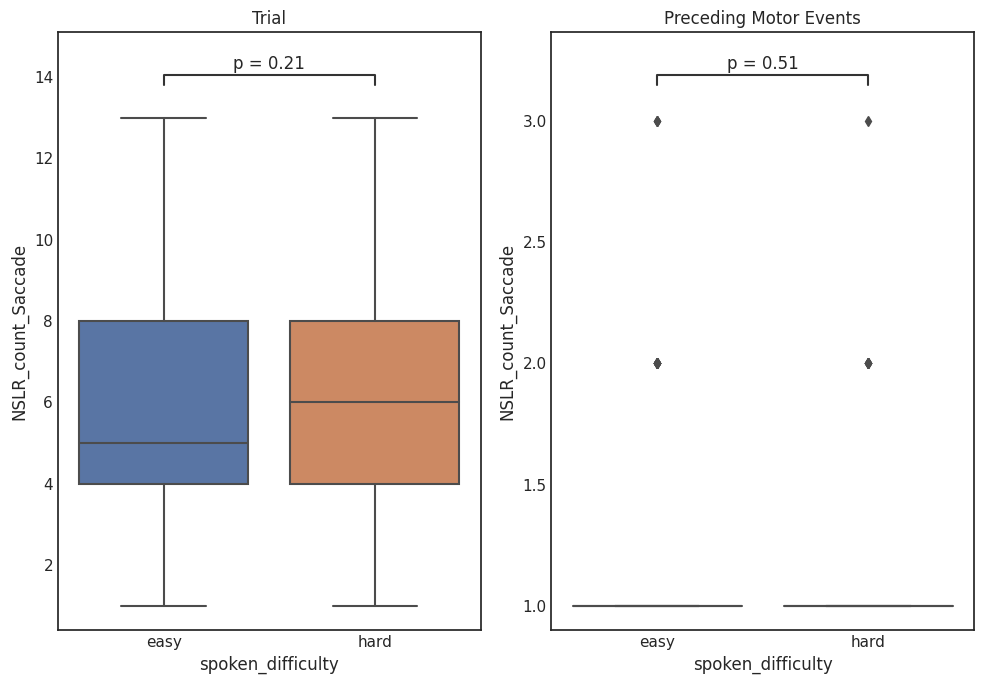

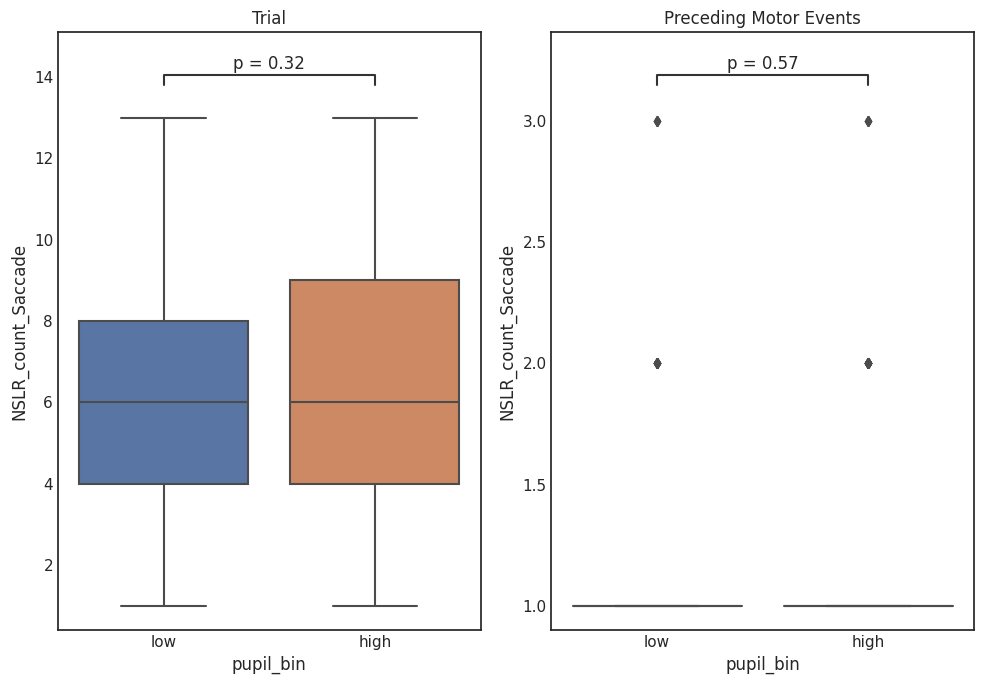

In [101]:
compare_motor_trial(trial_dfs, motor_dfs, y='NSLR_count_Saccade', x='spoken_difficulty', ylabel='Perceived difficulty', order=['easy','hard'])
compare_motor_trial(trial_dfs, motor_dfs, y='NSLR_count_Saccade', x='pupil_bin', order=['low','high'])


## Fixation

### Condition split

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


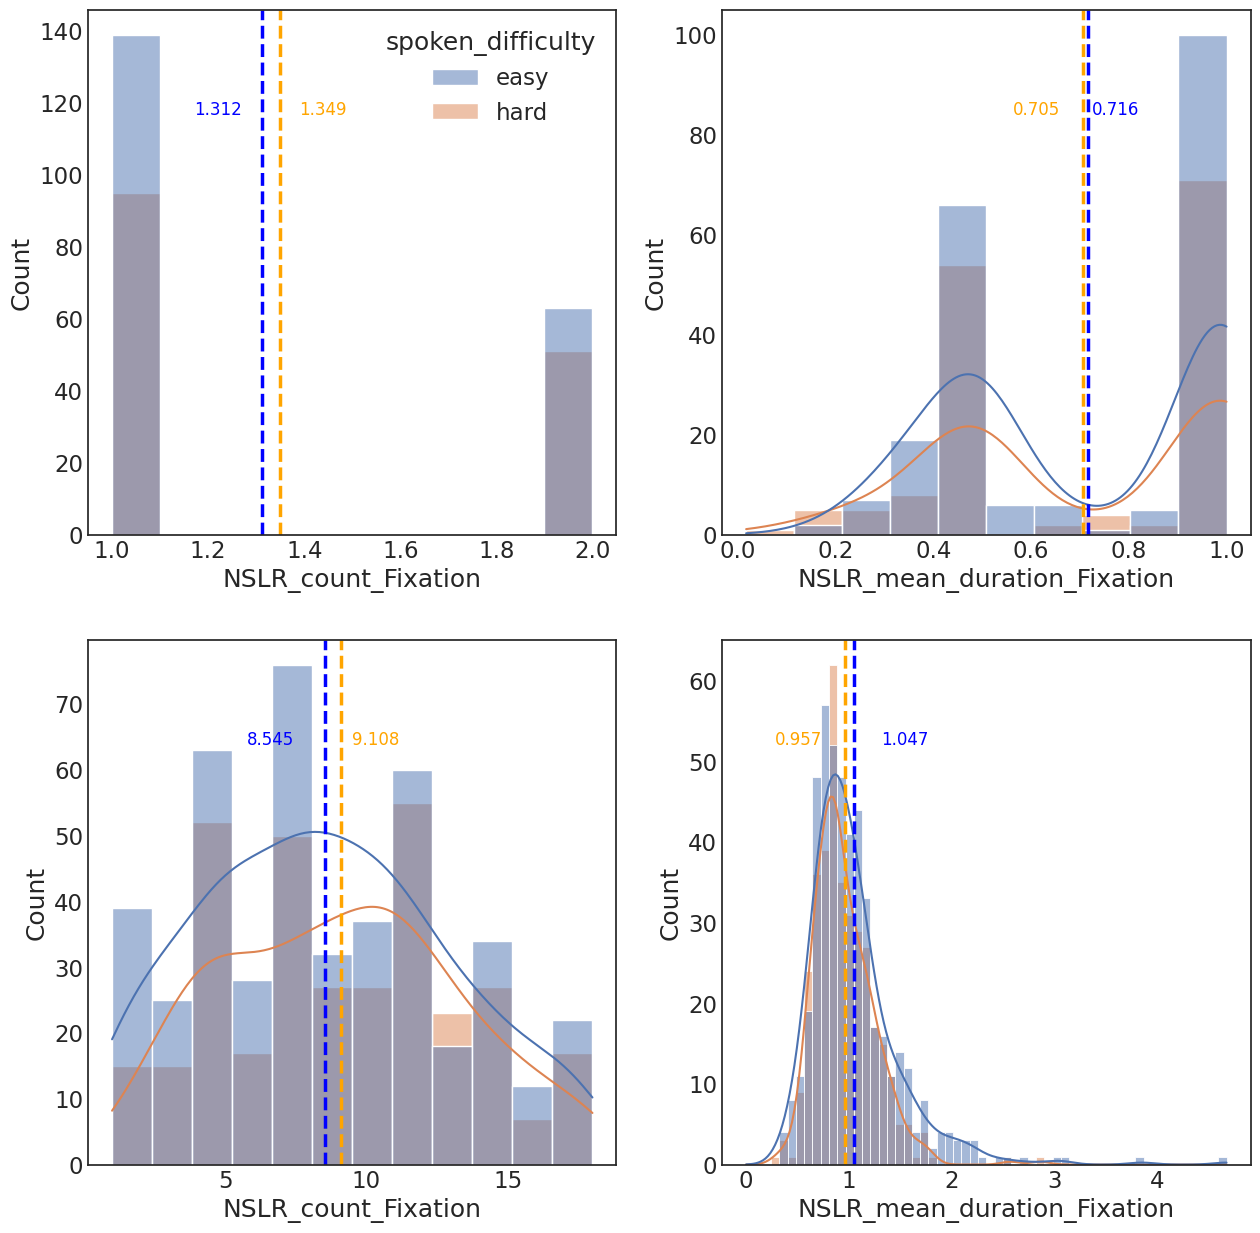

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
left_measure = 'NSLR_count_Fixation'
right_measure = 'NSLR_mean_duration_Fixation'
hue='spoken_difficulty'
hue_order = ['easy','hard']
sns.histplot(data=motor_dfs, x=left_measure, kde=False, ax=axs[0, 0], hue=hue, hue_order=hue_order)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.2,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.4,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=motor_dfs, x=right_measure, legend=False, kde=True, ax=axs[0, 1], hue=hue, hue_order=hue_order)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.9,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.75,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=left_measure, kde=True, legend=False, ax=axs[1, 0], hue=hue, hue_order=hue_order)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=right_measure, kde=True, ax=axs[1, 1], hue=hue, hue_order=hue_order)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)


plt.legend() 
plt.show()

### Pupil split

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


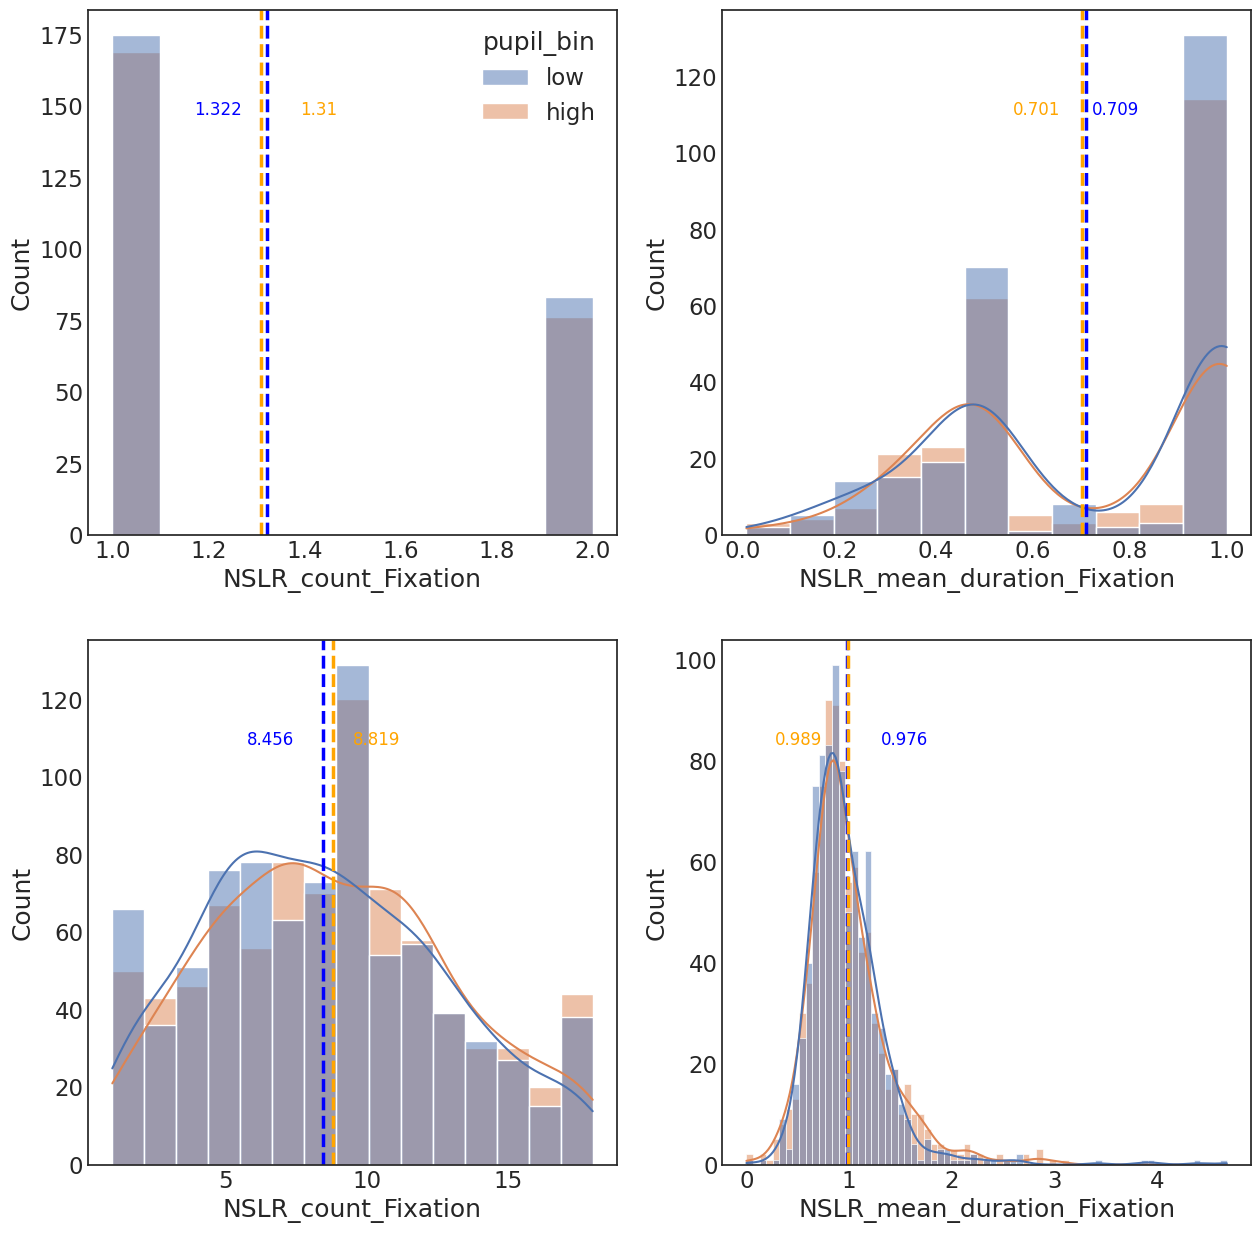

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
left_measure = 'NSLR_count_Fixation'
right_measure = 'NSLR_mean_duration_Fixation'
hue='pupil_bin'
hue_order = ['low','high']
sns.histplot(data=motor_dfs, x=left_measure, kde=False, ax=axs[0, 0], hue=hue, hue_order=hue_order)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.2,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.4,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=motor_dfs, x=right_measure, legend=False, kde=True, ax=axs[0, 1], hue=hue, hue_order=hue_order)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.9,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.75,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=left_measure, kde=True, legend=False, ax=axs[1, 0], hue=hue, hue_order=hue_order)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=right_measure, kde=True, ax=axs[1, 1], hue=hue, hue_order=hue_order)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)


plt.legend() 
plt.show()

## Saccades

### Condition

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


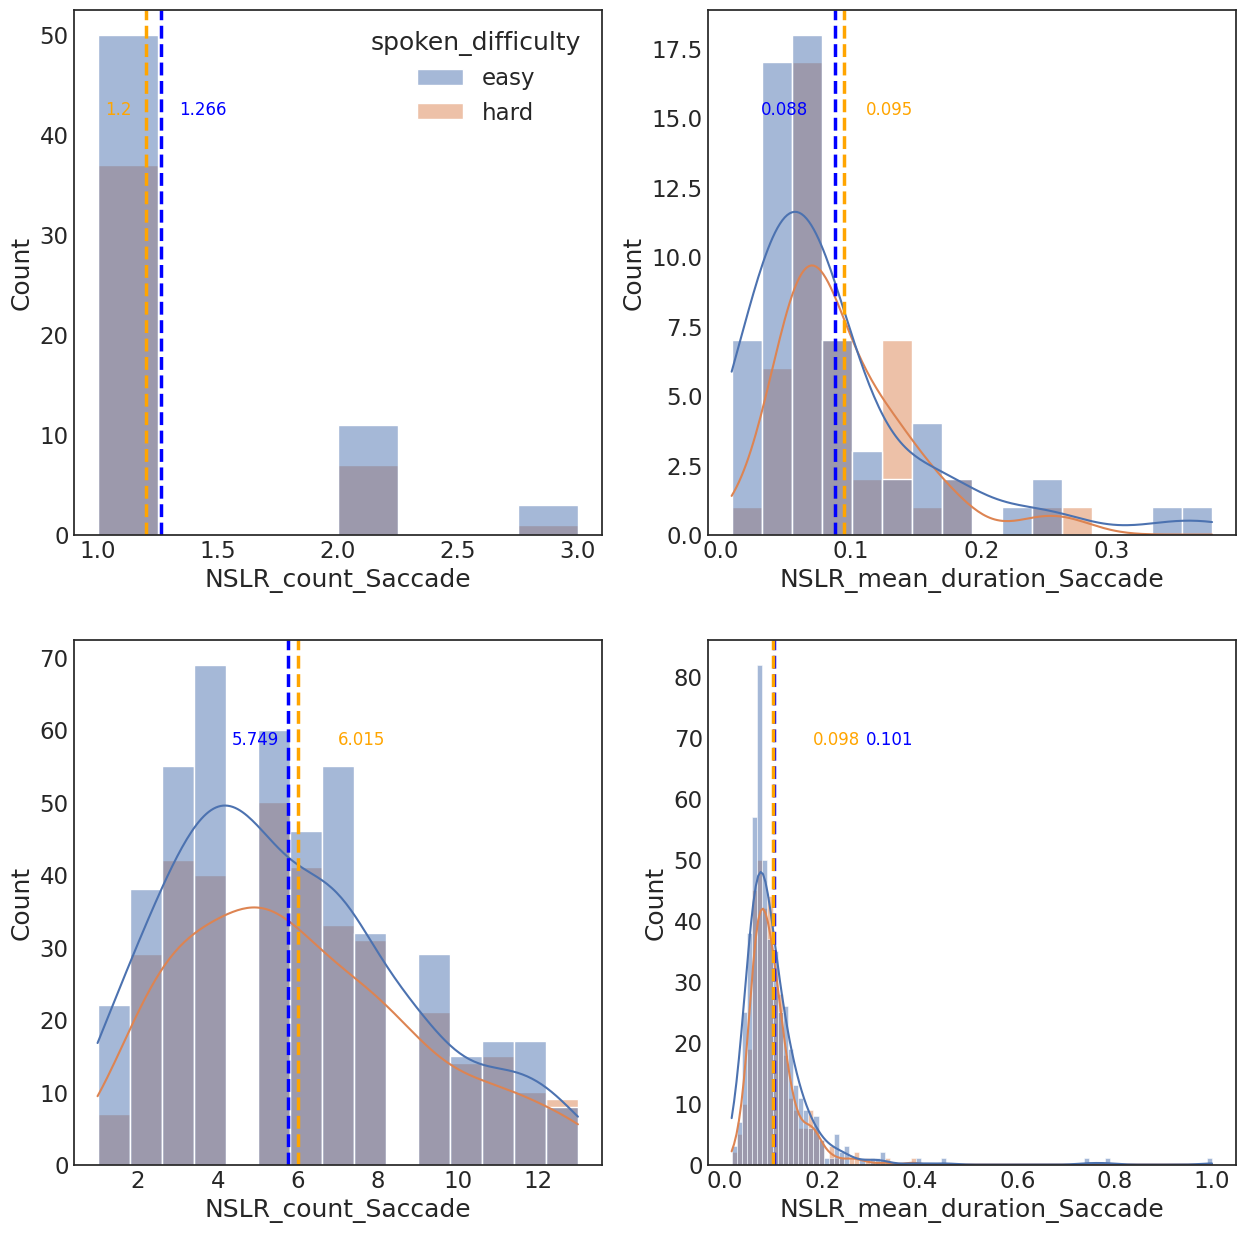

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
left_measure = 'NSLR_count_Saccade'
right_measure = 'NSLR_mean_duration_Saccade'
hue='spoken_difficulty'
hue_order = ['easy','hard']
sns.histplot(data=motor_dfs, x=left_measure, kde=False, ax=axs[0, 0], hue=hue, hue_order=hue_order)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.2,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.06,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=motor_dfs, x=right_measure, legend=False, kde=True, ax=axs[0, 1], hue=hue, hue_order=hue_order)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.3,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.5,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=left_measure, kde=True, legend=False, ax=axs[1, 0], hue=hue, hue_order=hue_order)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=right_measure, kde=True, ax=axs[1, 1], hue=hue, hue_order=hue_order)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.4,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)


plt.legend() 
plt.show()

### Pupil

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


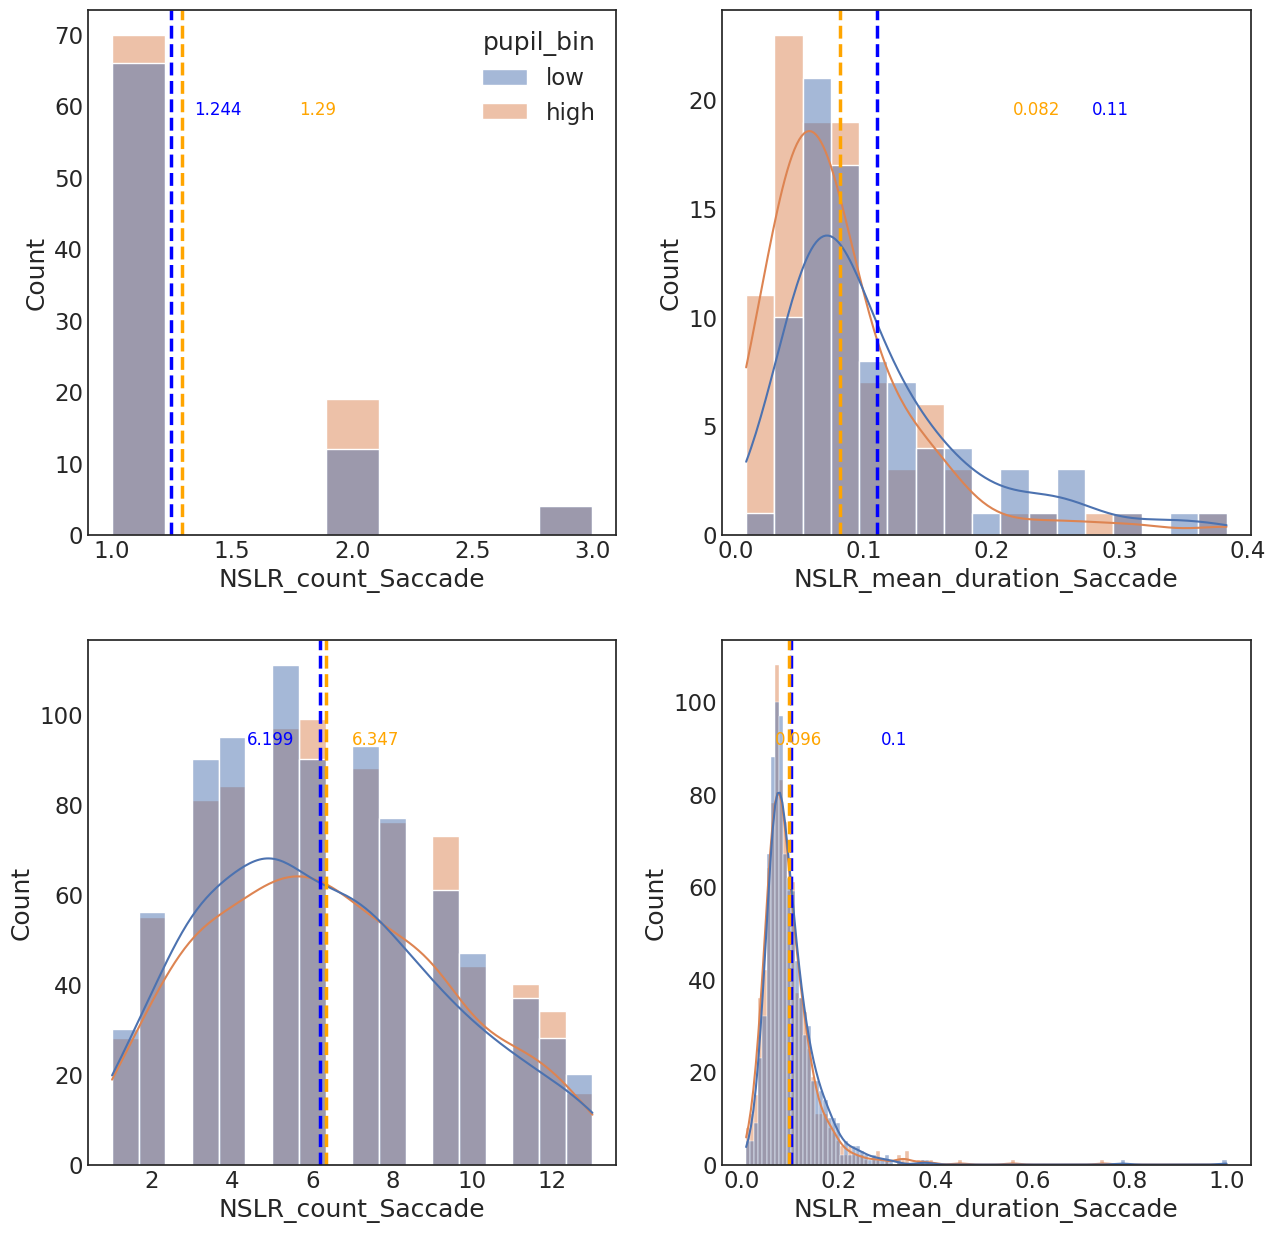

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
left_measure = 'NSLR_count_Saccade'
right_measure = 'NSLR_mean_duration_Saccade'
hue='pupil_bin'
hue_order = ['low','high']
sns.histplot(data=motor_dfs, x=left_measure, kde=False, ax=axs[0, 0], hue=hue, hue_order=hue_order)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.2,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 0].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.4,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=motor_dfs, x=right_measure, legend=False, kde=True, ax=axs[0, 1], hue=hue, hue_order=hue_order)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.9,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.75,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=left_measure, kde=True, legend=False, ax=axs[1, 0], hue=hue, hue_order=hue_order)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=right_measure, kde=True, ax=axs[1, 1], hue=hue, hue_order=hue_order)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)


plt.legend() 
plt.show()

## PMC Alpha Activity

### Condition

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


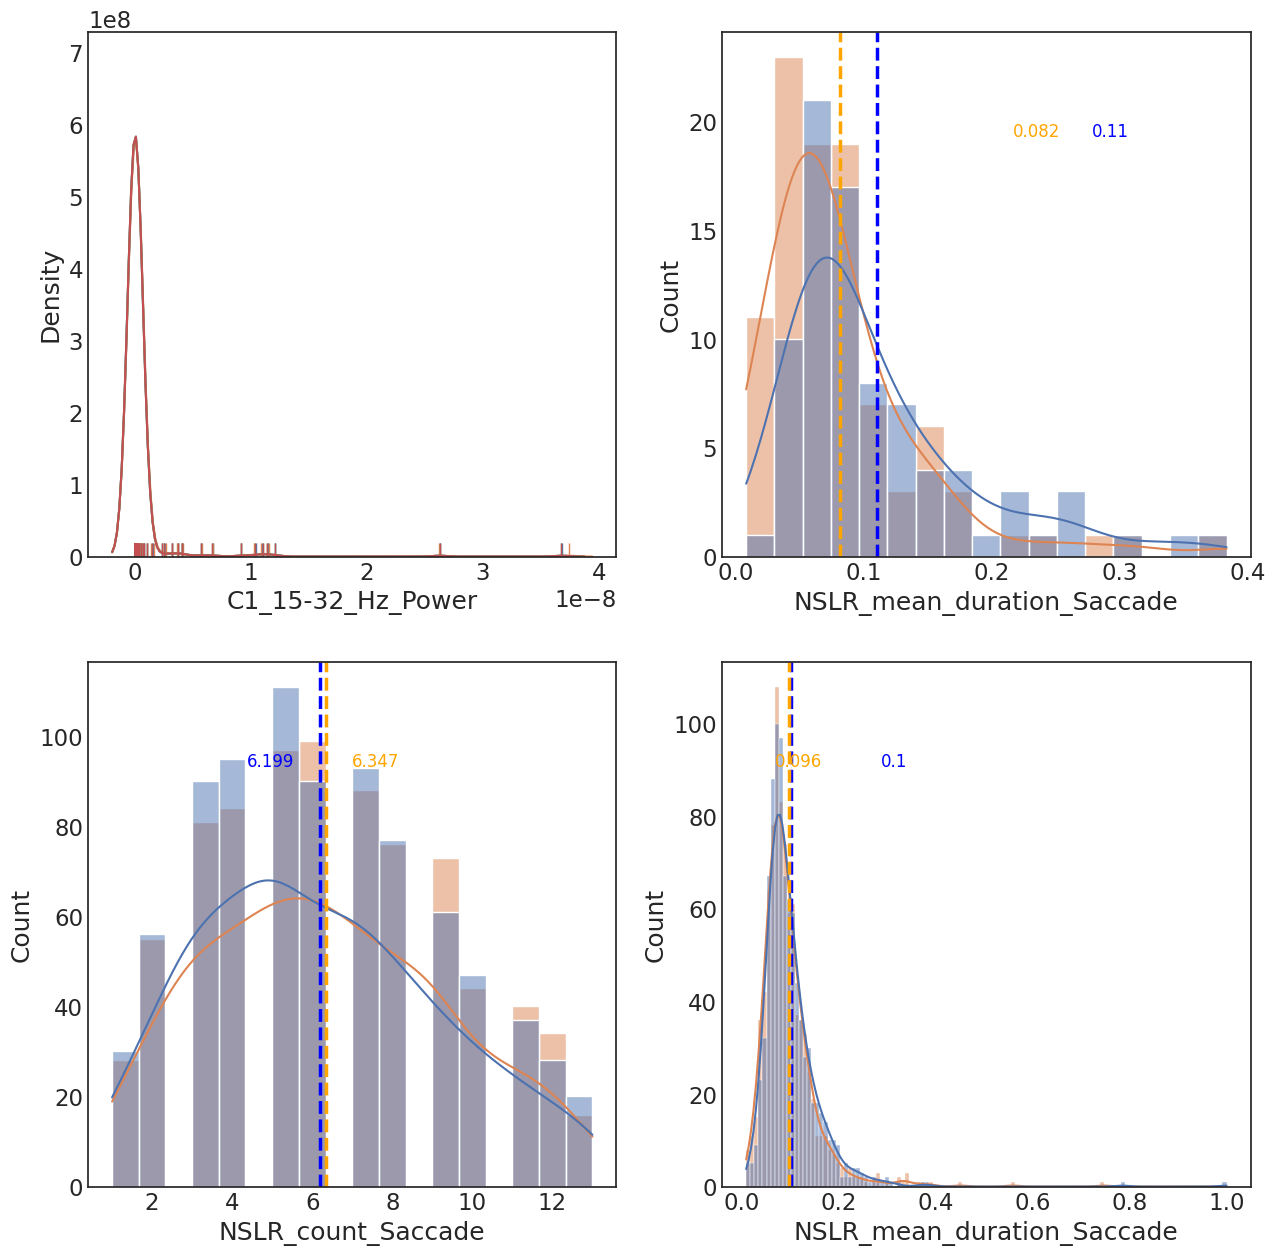

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
channels = ['FC1_15-32_Hz_Power', 'FC3_15-32_Hz_Power', 'C1_15-32_Hz_Power', 'C3_15-32_Hz_Power']
left_measure = 'NSLR_count_Saccade'
right_measure = 'NSLR_mean_duration_Saccade'
hue='pupil_bin'
hue_order = ['low','high']
sns.distplot(motor_dfs[channels[0]], hist=False, rug=True, ax=axs[0, 0])
sns.distplot(motor_dfs[channels[1]], hist=False, rug=True, ax=axs[0, 0])
sns.distplot(motor_dfs[channels[2]], hist=False, rug=True, ax=axs[0, 0])
sns.distplot(motor_dfs[channels[3]], hist=False, rug=True, ax=axs[0, 0])

sns.histplot(data=motor_dfs, x=right_measure, legend=False, kde=True, ax=axs[0, 1], hue=hue, hue_order=hue_order)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.9,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[0, 1].axvline(x=motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[0, 1].text(1.75,.8, round(motor_dfs.loc[motor_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=left_measure, kde=True, legend=False, ax=axs[1, 0], hue=hue, hue_order=hue_order)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],left_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 0].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],left_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)

sns.histplot(data=trial_dfs, x=right_measure, kde=True, ax=axs[1, 1], hue=hue, hue_order=hue_order)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.5,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[0],right_measure].mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)
axs[1, 1].axvline(x=trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),
            color='orange',
            ls='--', 
            lw=2.5)
axs[1, 1].text(1.3,-.4, round(trial_dfs.loc[trial_dfs[hue]==hue_order[1],right_measure].mean(),3), color='orange', fontsize = 12, transform=axs[0, 0].transAxes)


plt.legend() 
plt.show()

# Read Results

In [5]:
all_dfs = pd.read_excel(f"{output_dir}all_results_motor.xlsx")

Text(0.5, 1.0, 'Proportional time into the trial when voice feedback was recognized')

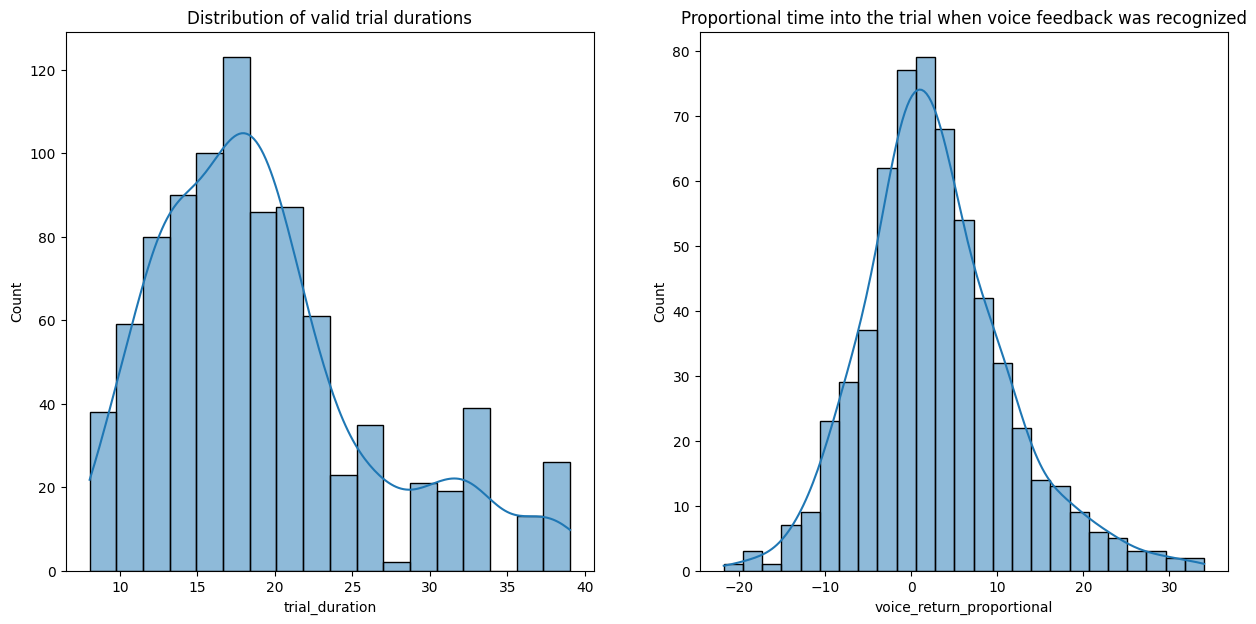

In [8]:
%matplotlib inline

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

all_dfs_final = all_dfs.copy()
all_dfs_final = all_dfs_final[all_dfs_final.trial_duration <= 40]
all_dfs_final.voice_timestamp = all_dfs_final.voice_timestamp - 1
all_dfs_final['voice_return_proportional'] = (all_dfs_final.voice_timestamp-all_dfs_final.trial_start_time)/(all_dfs_final.trial_end_time-all_dfs_final.trial_start_time)
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

sns.histplot(data=all_dfs_final, x="trial_duration", kde=True, ax=axs[0])
sns.histplot(data=all_dfs_final, x="voice_return_proportional", kde=True, ax=axs[1])
axs[0].set_title('Distribution of valid trial durations')
axs[1].set_title('Proportional time into the trial when voice feedback was recognized')

# Data filtering and prep

In [ ]:
# seaborn
sns.set(font_scale=1.2)
sns.set_palette("tab10")
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials
all_dfs_final = clean_up_adadrive_trials(all_dfs)
cols_of_interest = ["bpm", "density", "trial_duration", "trial_damage",
                                         "abs_sum_delta_steer_input", "abs_sum_delta_brake_input",
                                         "NSLR_count_Fixation", "NSLR_count_Saccade"]
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['spoken_difficulty','Left Pupil Diameter', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation','NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['spoken_difficulty','density','bpm','sdnn', 'rmssd','pnn50'] # rmssd = parasympathetic
motor_cols = ['spoken_difficulty','density','abs_sum_delta_steer_input','abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input'] 


# damage change
all_dfs_final = all_dfs_final.sort_values(by=['ppid', 'session', 'block'])

# nan, outliers
for col in cols_of_interest:
    all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
all_dfs_final['abs_sum_delta_brake_input'] = all_dfs_final['abs_sum_delta_brake_input'].mask(all_dfs_final['abs_sum_delta_brake_input']>.1)
all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation']-all_dfs_final['trial_start_time']
all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade']-all_dfs_final['trial_start_time']
all_dfs_final['bpm'] = all_dfs_final['bpm'].mask((all_dfs_final['bpm']<40) | (all_dfs_final['bpm']>150))

# 10-19-22 Meeting

In [9]:
# seaborn
%matplotlib inline

sns.set(font_scale=1.2)
sns.set_palette("tab10")
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials
all_dfs_final = clean_up_adadrive_trials(all_dfs)
cols_of_interest = ["bpm", "density", "trial_duration", "trial_damage",
                                         "NSLR_count_Fixation", "NSLR_count_Saccade"]
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['spoken_difficulty','Left Pupil Diameter', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation','NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['spoken_difficulty','density','bpm','sdnn', 'rmssd','pnn50'] # rmssd = parasympathetic
motor_cols = ['spoken_difficulty','density','abs_sum_delta_steer_input','abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input'] 


# damage change
all_dfs_final = all_dfs_final.sort_values(by=['ppid', 'session', 'block'])

# nan, outliers
for col in cols_of_interest:
    all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation']-all_dfs_final['trial_start_time']
all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade']-all_dfs_final['trial_start_time']
all_dfs_final['bpm'] = all_dfs_final['bpm'].mask((all_dfs_final['bpm']<40) | (all_dfs_final['bpm']>150))

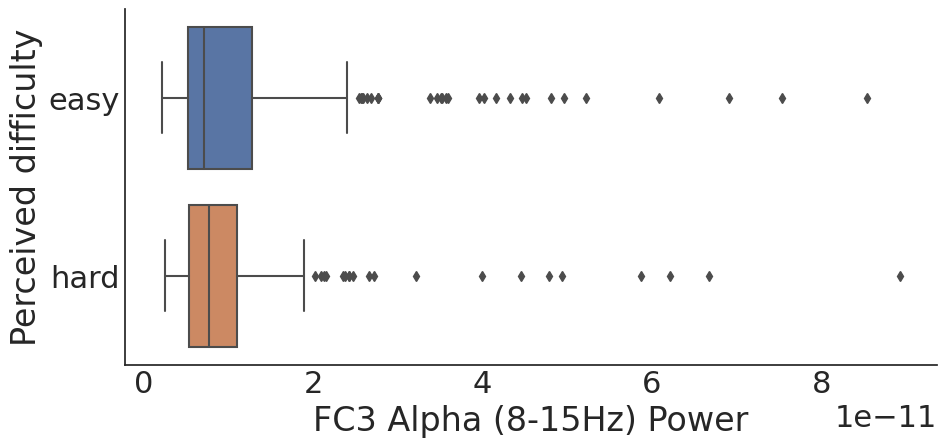

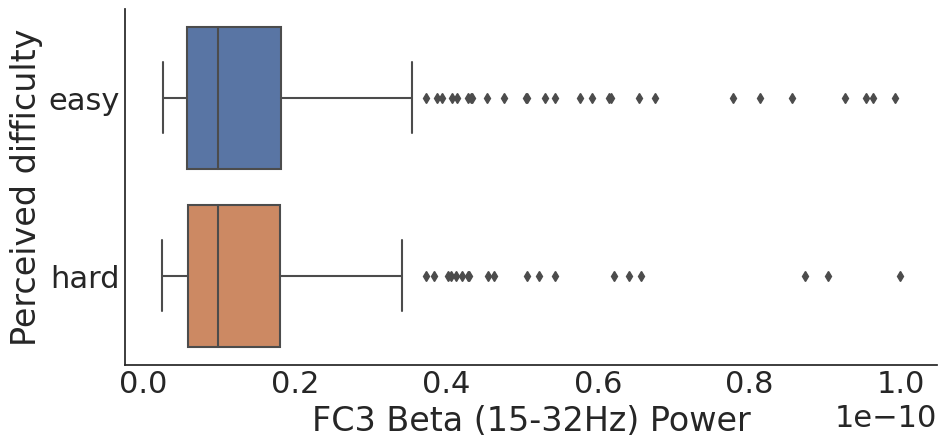

In [19]:
sns.set(font_scale=2)
plt.style.use('seaborn-white')

def plot_eeg_comparison(channel, frequency, plot_label_freq):
    # some preliminary filters for data viz
    coe_eeg_copy = all_dfs_final.copy()
    coe_eeg_copy = coe_eeg_copy.loc[coe_eeg_copy[f"{channel}_{frequency}_Hz_Power"] < 1e-10]
    g = sns.catplot(data=coe_eeg_copy, y="spoken_difficulty", x=f"{channel}_{frequency}_Hz_Power", kind="box", order=['easy','hard'], aspect=2)
    g.set_axis_labels(f"{channel} {plot_label_freq} ({frequency}Hz) Power", "Perceived difficulty")
    #plt.savefig('output/coe_eeg.png', dpi=300)

plot_eeg_comparison('FC1', '8-15', 'Alpha')
plot_eeg_comparison('FC3', '15-32', 'Beta')




# 10-12-22 Meeting

## Opacity effects on pupil diameter

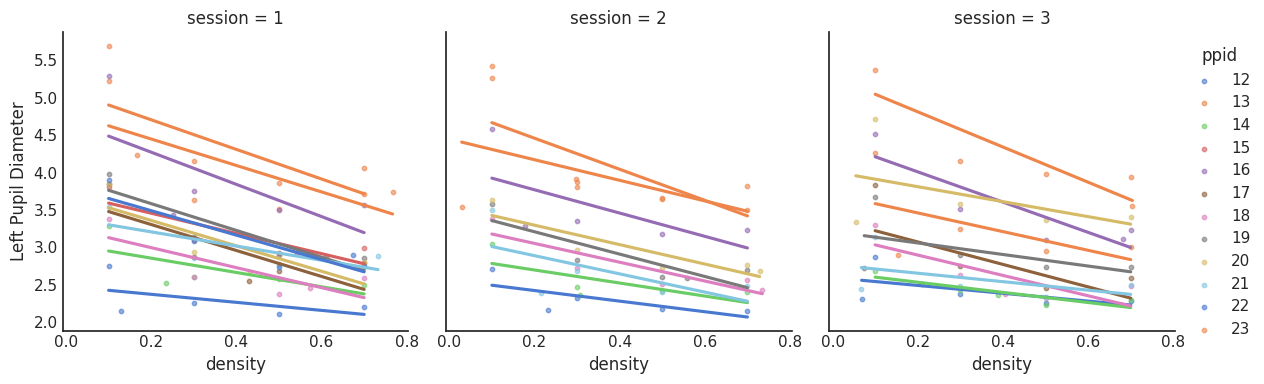

In [88]:
# performance measure: speeed

sns.set(font_scale=1)
plt.style.use('seaborn-white')
practice_df = all_dfs[all_dfs.block_condition=='practice']
sns.lmplot(
    data=practice_df, x="density", y="Left Pupil Diameter", col="session", hue="ppid",
    palette="muted", ci=None, row_order=['easy','hard'],
    height=4, scatter_kws={"s": 10, "alpha": .6}
)


## Practice effect?

In [15]:
all_dfs_final

trial_start_time  trial_end_time  ppid  session  block  number_in_block  \
74        4165.101293     4166.101293  12.0      1.0    3.0              6.0   
75        4167.728635     4168.728635  12.0      1.0    3.0              6.0   
76        4334.812631     4335.812631  12.0      1.0    5.0              2.0   
77        4337.220045     4338.220045  12.0      1.0    5.0              2.0   
78        4339.395124     4340.395124  12.0      1.0    5.0              2.0   
..                ...             ...   ...      ...    ...              ...   
918       2561.997082     2562.997082  23.0      3.0   15.0              3.0   
919       2704.613626     2705.613626  23.0      3.0   16.0              4.0   
920       2708.541561     2709.541561  23.0      3.0   16.0              4.0   
921       2698.233677     2699.233677  23.0      3.0   16.0              4.0   
922       2707.830386     2708.830386  23.0      3.0   16.0              4.0   

     trial   density      damage  source  ...  PO4_Hjorth_Mobility  \
74    22.0  0.405075   90.767365     2.0  ...                  NaN   
75    22.0  0.405075   90.767365     2.0  ...                  NaN   
76    32.0  0.185976  289.686310     1.0  ...             0.875173   
77    32.0  0.185976  289.686310     1.0  ...             0.680147   
78    32.0  0.185976  289.686310     1.0  ...             0.686686   
..     ...       ...         ...     ...  ...                  ...   
918  103.0  0.537229   73.070412     1.0  ...                  NaN   
919  113.0  0.412569   96.270790     0.0  ...             0.786428   
920  113.0  0.412569   96.270790     0.0  ...             0.556960   
921  113.0  0.412569   96.270790     0.0  ...             0.365115   
922  113.0  0.412569   96.270790     0.0  ...             0.586189   

    O2_Hjorth_Mobility NSLR_count_None  NSLR_first_onset_None  \
74                 NaN             NaN                    NaN   
75                 NaN             NaN                    NaN   
76            1.307919             NaN                    NaN   
77            1.173258             NaN                    NaN   
78            0.995058             NaN                    NaN   
..                 ...             ...                    ...   
918                NaN             NaN                    NaN   
919           1.252853             NaN                    NaN   
920           1.060947             NaN                    NaN   
921           0.770790             NaN                    NaN   
922           1.062869             NaN                    NaN   

    NSLR_mean_duration_None  measures  NSLR_count_Non  NSLR_first_onset_Non  \
74                      NaN       NaN             NaN                   NaN   
75                      NaN       NaN             NaN                   NaN   
76                      NaN       NaN             NaN                   NaN   
77                      NaN       NaN             NaN                   NaN   
78                      NaN       NaN             NaN                   NaN   
..                      ...       ...             ...                   ...   
918                     NaN       NaN             NaN                   NaN   
919                     NaN       NaN             NaN                   NaN   
920                     NaN       NaN             NaN                   NaN   
921                     NaN       NaN             NaN                   NaN   
922                     NaN       NaN             NaN                   NaN   

     NSLR_mean_duration_Non ppid_session  
74                      NaN         12_1  
75                      NaN         12_1  
76                      NaN         12_1  
77                      NaN         12_1  
78                      NaN         12_1  
..                      ...          ...  
918                     NaN         23_3  
919                     NaN         23_3  
920                     NaN         23_3  
921                     NaN         23_3  


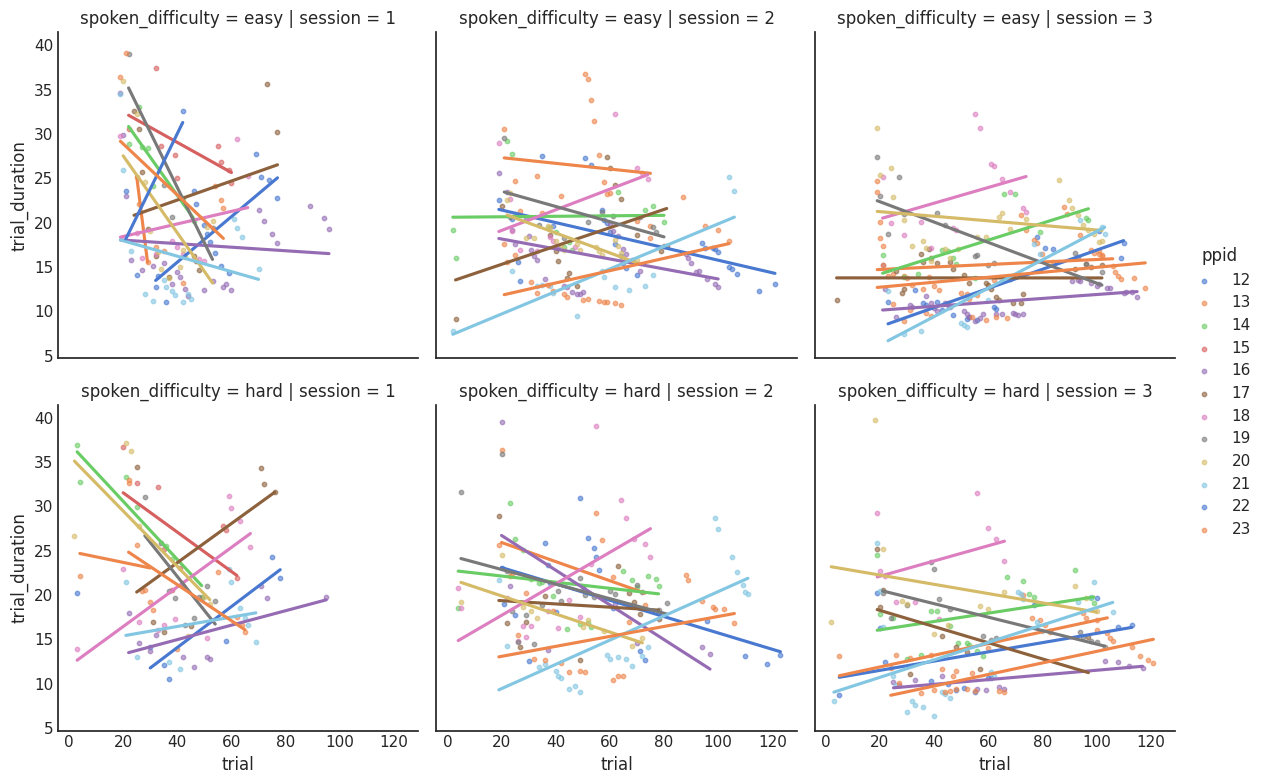

In [7]:
# performance measure: speeed

sns.set(font_scale=1)
plt.style.use('seaborn-white')

sns.lmplot(
    data=all_dfs_final, x="trial", y="trial_duration", col="session", hue="ppid", row='spoken_difficulty',
    palette="muted", ci=None, row_order=['easy','hard'],
    height=4, scatter_kws={"s": 10, "alpha": .6}
)


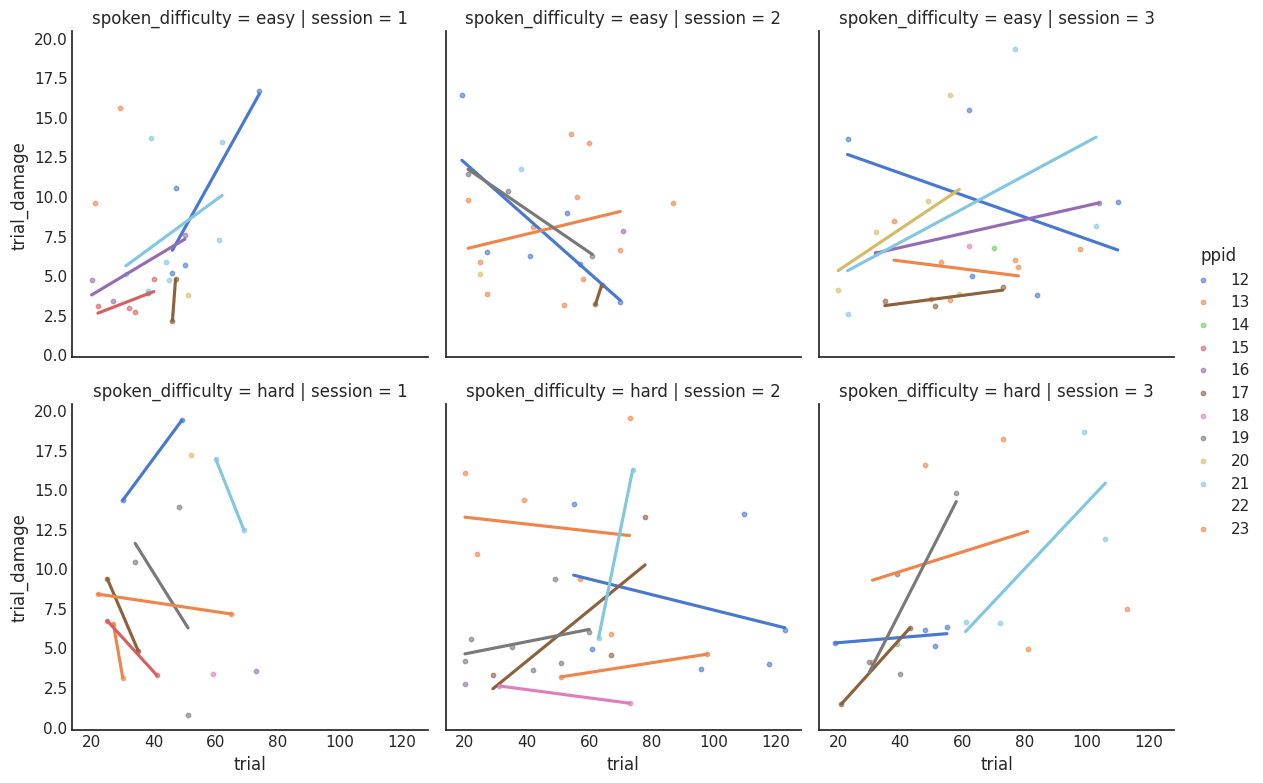

In [84]:
# performance measure: damange

sns.set(font_scale=1)
plt.style.use('seaborn-white')
trial_damage_df = all_dfs_final[all_dfs_final.trial_damage > 0]
sns.lmplot(
    data=trial_damage_df, x="trial", y="trial_damage", col="session", hue="ppid", row='spoken_difficulty',
    palette="muted", ci=None, row_order=['easy','hard'],
    height=4, scatter_kws={"s": 10, "alpha": .6}
)


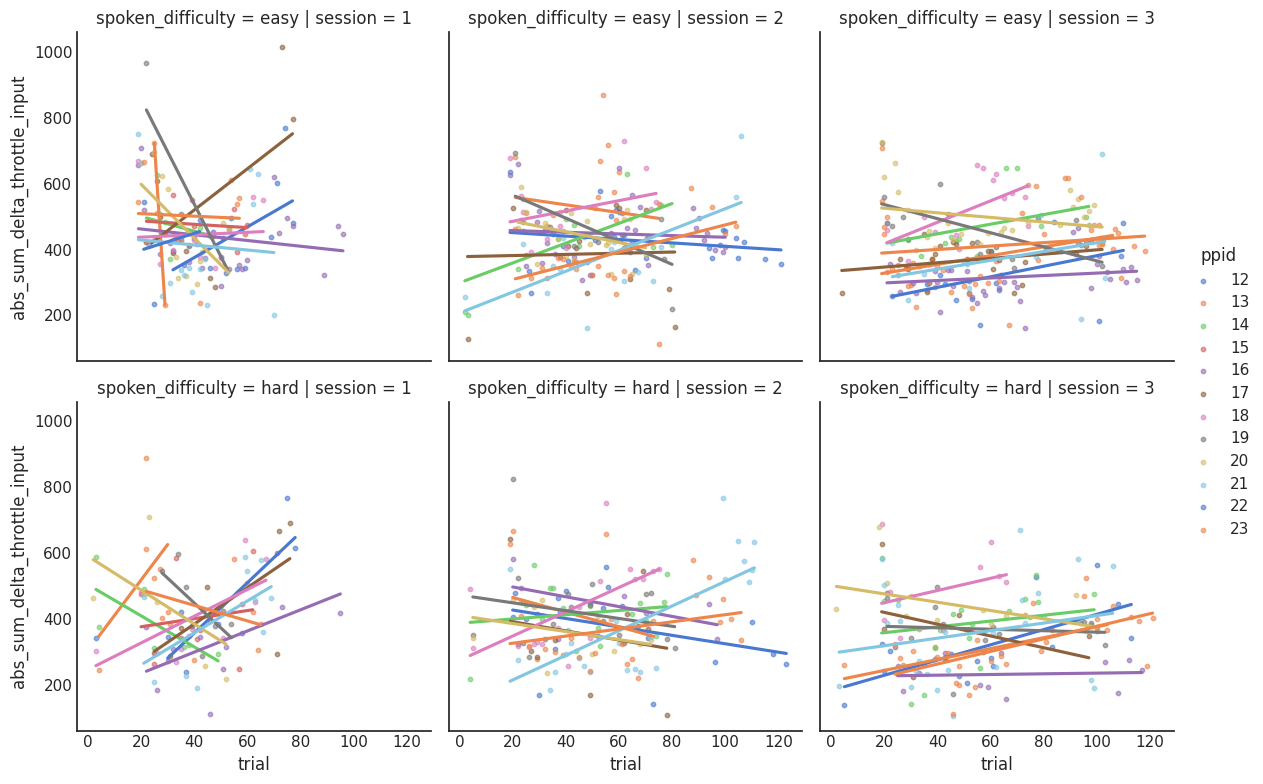

In [14]:
# performance measure: throttle input

sns.set(font_scale=1)
plt.style.use('seaborn-white')

sns.lmplot(
    data=all_dfs_final, x="trial", y="abs_sum_delta_throttle_input", col="session", hue="ppid", row='spoken_difficulty',
    palette="muted", ci=None, row_order=['easy','hard'],
    height=4, scatter_kws={"s": 10, "alpha": .6}
)


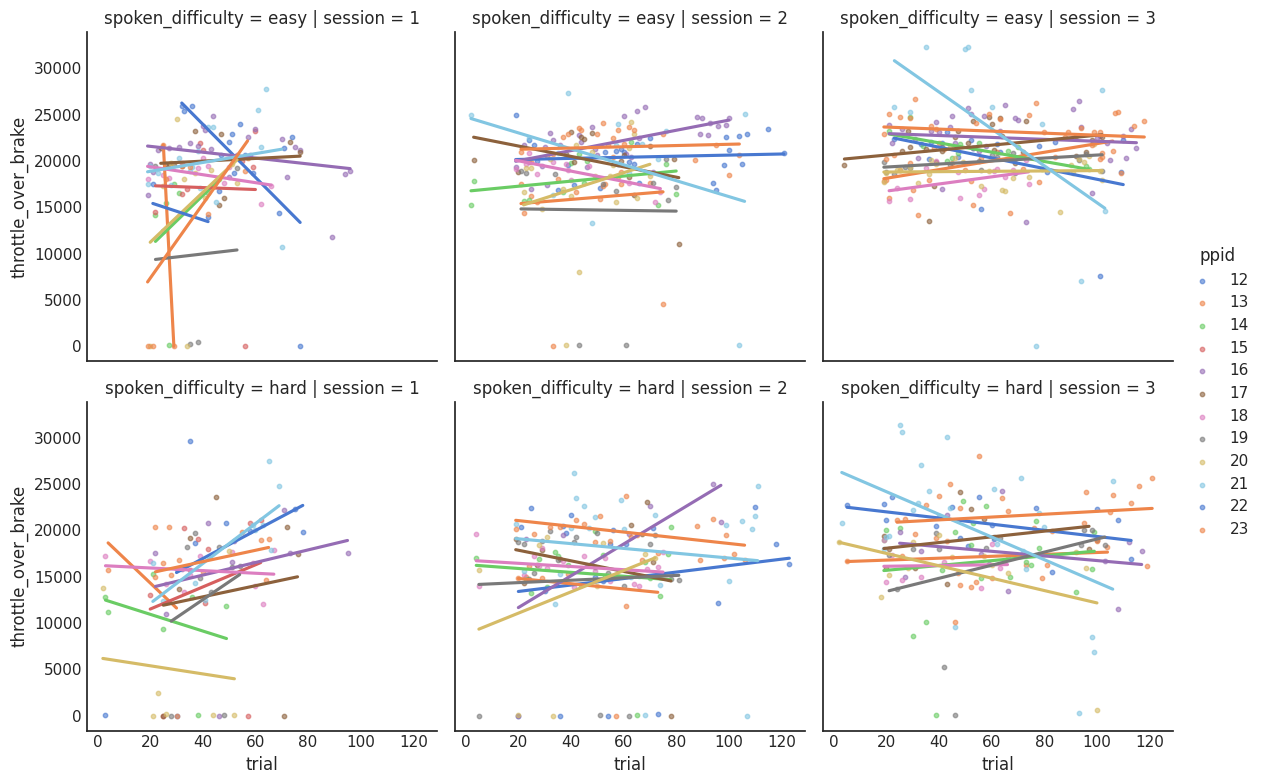

In [17]:
# performance measure: throttle input

sns.set(font_scale=1)
plt.style.use('seaborn-white')
performance_df = all_dfs_final.copy()
performance_df['throttle_over_brake'] = performance_df.abs_sum_delta_throttle_input/performance_df.abs_sum_delta_brake_input
sns.lmplot(
    data=performance_df, x="trial", y="throttle_over_brake", col="session", hue="ppid", row='spoken_difficulty',
    palette="muted", ci=None, row_order=['easy','hard'],
    height=4, scatter_kws={"s": 10, "alpha": .6}
)


In [ ]:
sns.regplot(x="trial_damage", y="throttle_over_brake", data=performance_df);

### Arousal performance relationship

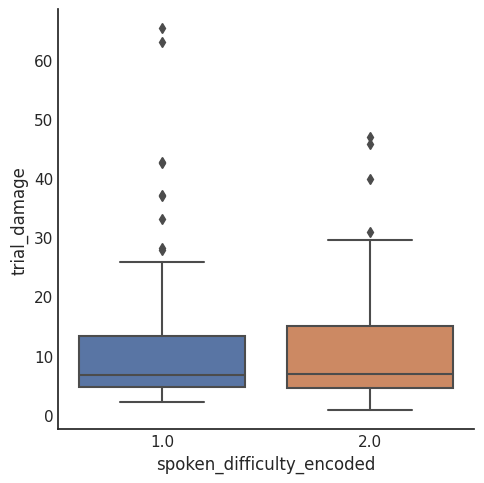

In [31]:
# perceived arousal
sns.catplot(x="spoken_difficulty_encoded", y="trial_damage", data=performance_df[performance_df.trial_damage > 0], kind="box");

# pupil-linked arousal
# sns.regplot(x="Left Pupil Diameter", y="throttle_over_brake", data=performance_df);

## Other

In [21]:
# quality measurse
speech_recognition = pd.DataFrame(all_dfs_final.groupby("ppid_session").apply(lambda x: x['spoken_difficulty'].notnull().mean()))
display('speech_recognition_min',speech_recognition.min().values,
        'speech_recognition_max',speech_recognition.max(),
        'speech_recognition.mean', speech_recognition.mean())
autorejected = pd.DataFrame(all_dfs_final.groupby("ppid_session").apply(lambda x: np.nansum(x['autorejected'])/len(x['autorejected'])))
display('autorejected_trials_min',autorejected.min(),
        'autorejected_trials_max',autorejected.max(),
        'autorejected_trials_mean', autorejected.mean())
bad_beats = pd.DataFrame(all_dfs_final.groupby("ppid_session").apply(lambda x: x['removed_beat_rate']))
display('bad_beats_perc_min',bad_beats.min(),
        'bad_beats_perc_max',bad_beats.max(),
        'bad_beats_perc_mean', bad_beats.mean())


'speech_recognition_min'

array([0.35])

'speech_recognition_max'

0    0.634146
dtype: float64

'speech_recognition.mean'

0    0.516047
dtype: float64

'autorejected_trials_min'

0    0.0
dtype: float64

'autorejected_trials_max'

0    0.339286
dtype: float64

'autorejected_trials_mean'

0    0.041427
dtype: float64

'bad_beats_perc_min'

removed_beat_rate    0.0
dtype: float64

'bad_beats_perc_max'

removed_beat_rate    0.769231
dtype: float64

'bad_beats_perc_mean'

removed_beat_rate    0.219213
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


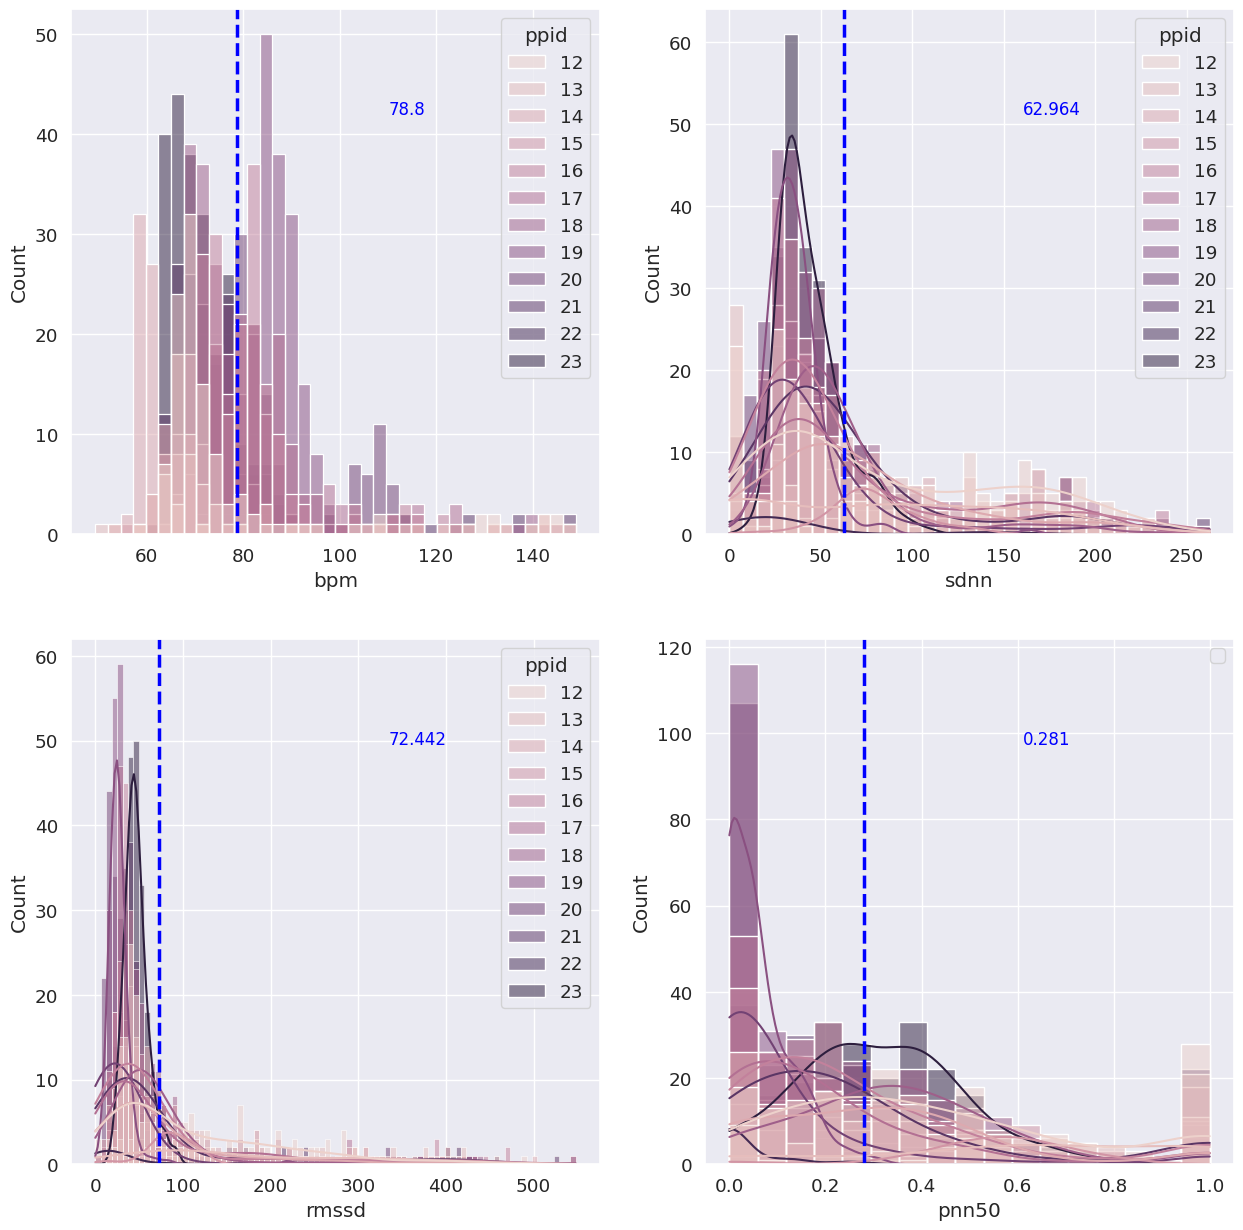

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.histplot(data=all_dfs_final, x="bpm", kde=False, color="skyblue", label="Sepal Length", ax=axs[0, 0], hue='ppid')
axs[0, 0].axvline(x=all_dfs_final.bpm.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.6,.8, round(all_dfs_final.bpm.mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)


sns.histplot(data=all_dfs_final, x="sdnn", kde=True, color="olive", ax=axs[0, 1], hue='ppid')
axs[0, 1].axvline(x=all_dfs_final.sdnn.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(0.6,.8, round(all_dfs_final.sdnn.mean(),3), color='blue', fontsize = 12, transform=axs[0, 1].transAxes)


sns.histplot(data=all_dfs_final, x="rmssd", kde=True, color="gold", ax=axs[1, 0], hue='ppid')
axs[1, 0].axvline(x=all_dfs_final.rmssd.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.6,.8, round(all_dfs_final.rmssd.mean(),3), color='blue', fontsize = 12, transform=axs[1, 0].transAxes)


sns.histplot(data=all_dfs_final, x="pnn50", kde=True, color="teal", ax=axs[1, 1], hue='ppid')
axs[1, 1].axvline(x=all_dfs_final.pnn50.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(0.6,.8, round(all_dfs_final.pnn50.mean(),3), color='blue', fontsize = 12, transform=axs[1, 1].transAxes)


plt.legend() 
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


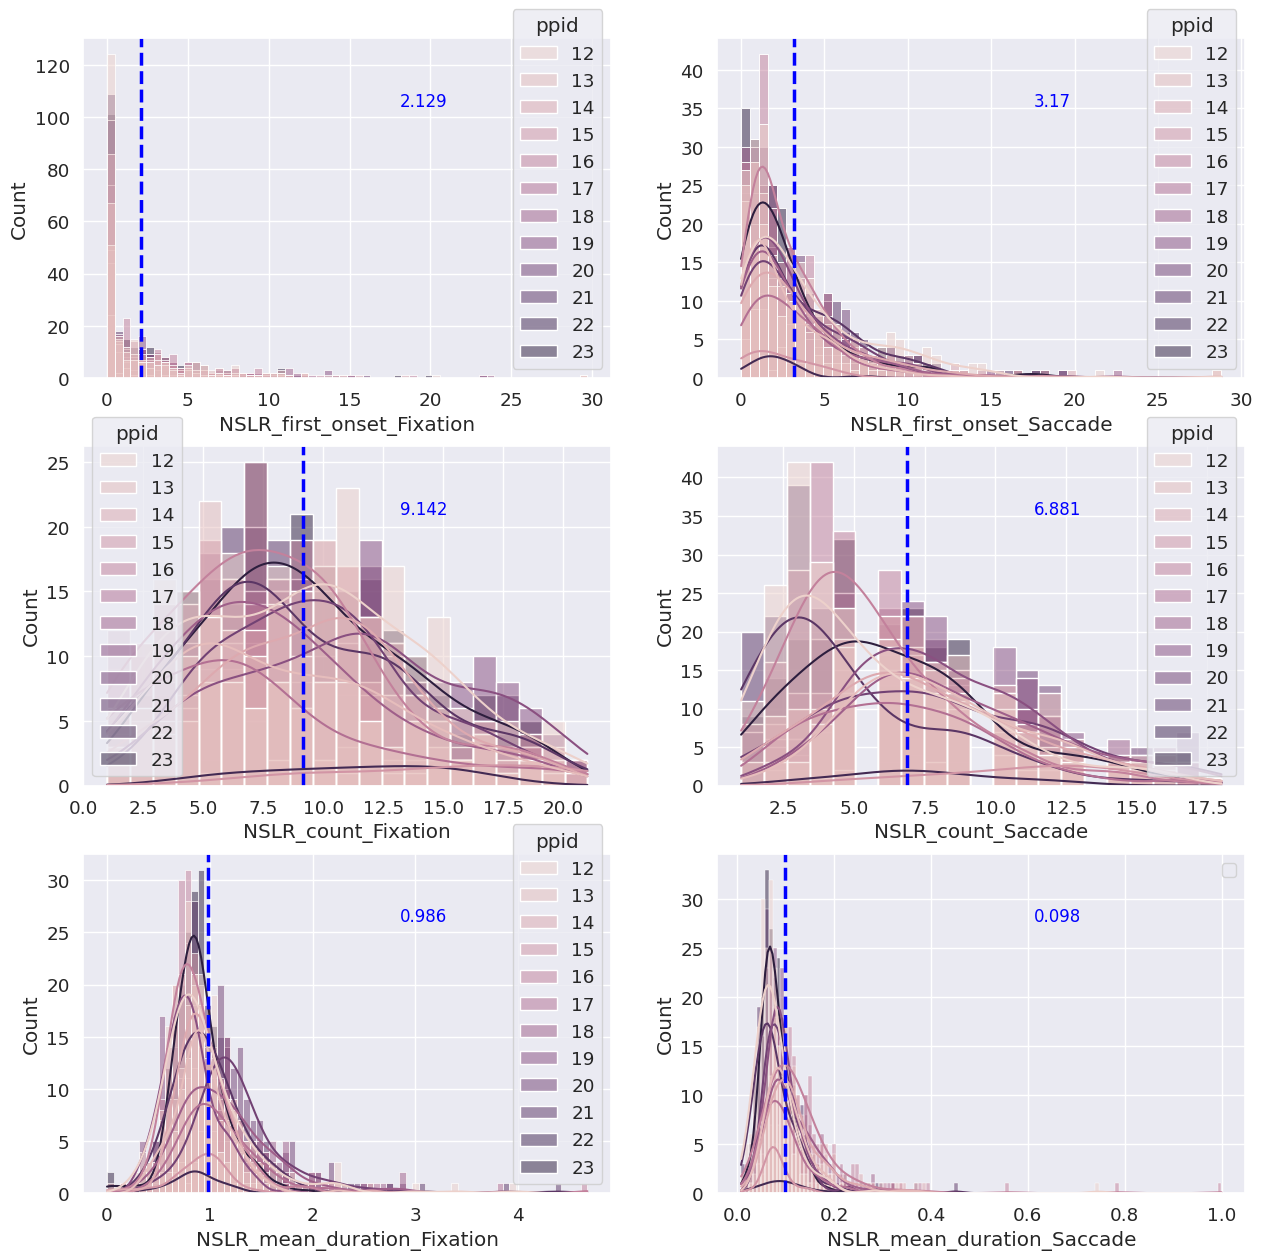

In [26]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
sns.histplot(data=all_dfs_final, x="NSLR_first_onset_Fixation", kde=False, color="skyblue", label="Sepal Length", ax=axs[0, 0], hue='ppid')
axs[0, 0].axvline(x=all_dfs_final.NSLR_first_onset_Fixation.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 0].text(0.6,.8, round(all_dfs_final.NSLR_first_onset_Fixation.mean(),3), color='blue', fontsize = 12, transform=axs[0, 0].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_first_onset_Saccade", kde=True, color="olive", ax=axs[0, 1], hue='ppid')
axs[0, 1].axvline(x=all_dfs_final.NSLR_first_onset_Saccade.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[0, 1].text(0.6,.8, round(all_dfs_final.NSLR_first_onset_Saccade.mean(),3), color='blue', fontsize = 12, transform=axs[0, 1].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_count_Fixation", kde=True, color="gold", ax=axs[1, 0], hue='ppid')
axs[1, 0].axvline(x=all_dfs_final.NSLR_count_Fixation.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 0].text(0.6,.8, round(all_dfs_final.NSLR_count_Fixation.mean(),3), color='blue', fontsize = 12, transform=axs[1, 0].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_count_Saccade", kde=True, color="teal", ax=axs[1, 1], hue='ppid')
axs[1, 1].axvline(x=all_dfs_final.NSLR_count_Saccade.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[1, 1].text(0.6,.8, round(all_dfs_final.NSLR_count_Saccade.mean(),3), color='blue', fontsize = 12, transform=axs[1, 1].transAxes)


sns.histplot(data=all_dfs_final, x="NSLR_mean_duration_Fixation", kde=True, color="gold", ax=axs[2, 0], hue='ppid')
axs[2, 0].axvline(x=all_dfs_final.NSLR_mean_duration_Fixation.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[2, 0].text(0.6,.8, round(all_dfs_final.NSLR_mean_duration_Fixation.mean(),3), color='blue', fontsize = 12, transform=axs[2, 0].transAxes)

sns.histplot(data=all_dfs_final, x="NSLR_mean_duration_Saccade", kde=True, color="teal", ax=axs[2, 1], hue='ppid')
axs[2, 1].axvline(x=all_dfs_final.NSLR_mean_duration_Saccade.mean(),
            color='blue',
            ls='--', 
            lw=2.5)
axs[2, 1].text(.6,.8, round(all_dfs_final.NSLR_mean_duration_Saccade.mean(),3), color='blue', fontsize = 12, transform=axs[2, 1].transAxes)

plt.legend() 
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


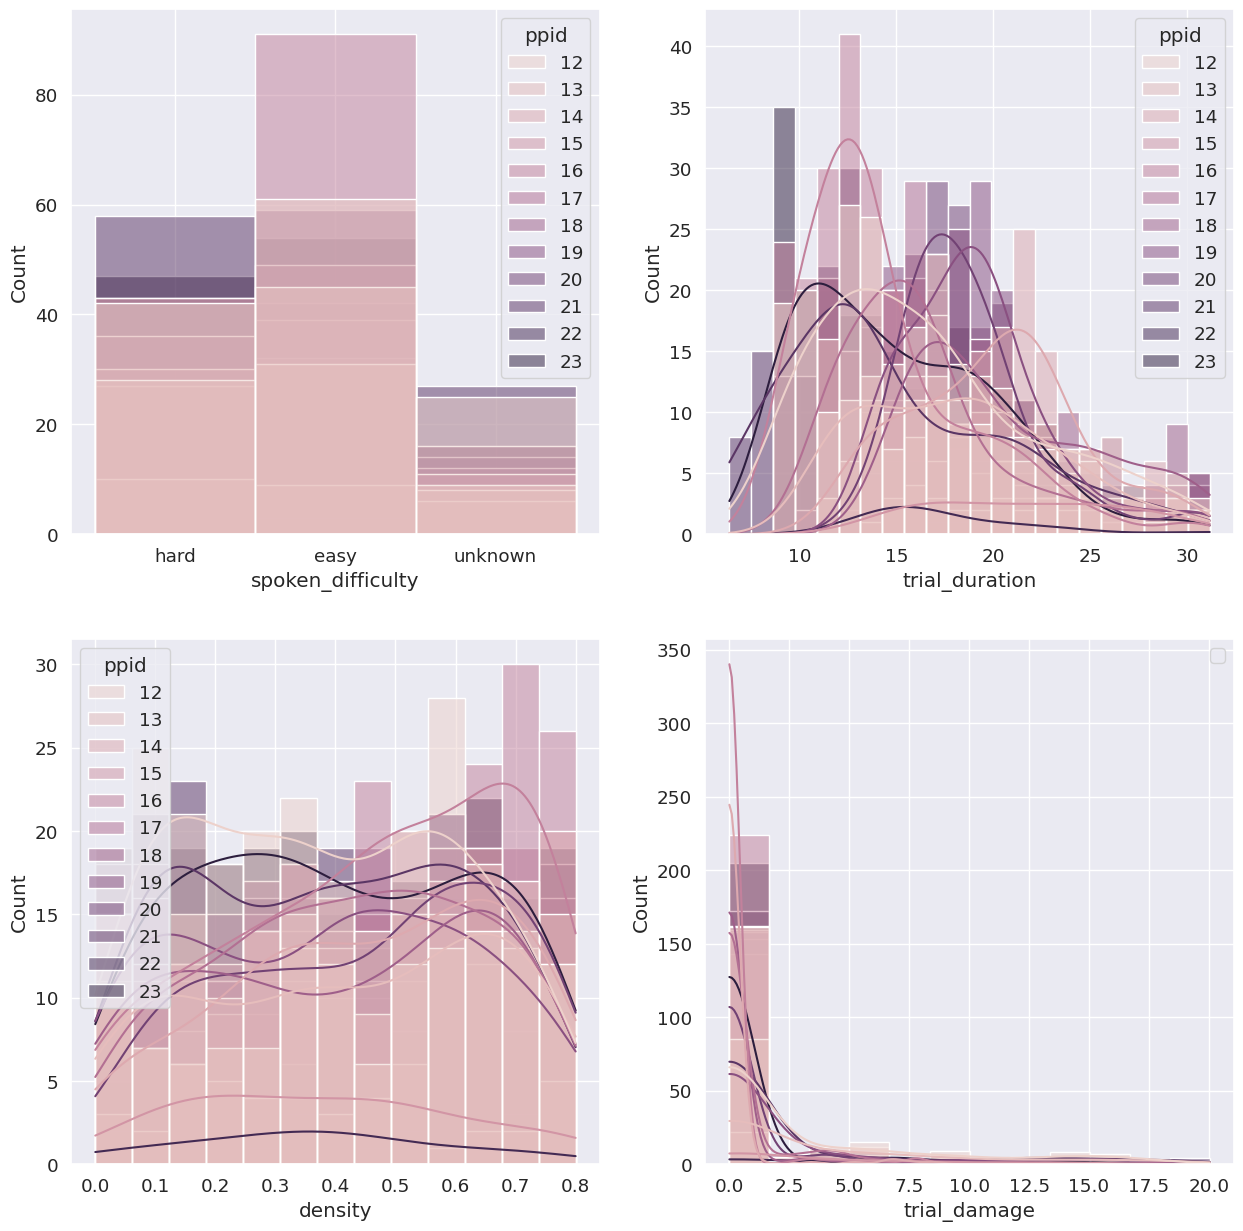

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.histplot(data=all_dfs_final, x="spoken_difficulty", kde=False, color="skyblue", label="Sepal Length", ax=axs[0, 0], hue='ppid')
sns.histplot(data=all_dfs_final, x="trial_duration", kde=True, color="olive", ax=axs[0, 1], hue='ppid')
sns.histplot(data=all_dfs_final, x="density", kde=True, color="gold", ax=axs[1, 0], hue='ppid')
sns.histplot(data=all_dfs_final, x="trial_damage", kde=True, color="teal", ax=axs[1, 1], hue='ppid')

plt.legend() 
plt.show()


## Josef's variables

In [25]:

all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'easy', 'spoken_difficulty'] = 1
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'hard', 'spoken_difficulty'] = 2
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'unknown', 'spoken_difficulty'] = np.NAN

all_dfs_final['spoken_difficulty'] = all_dfs_final['spoken_difficulty'].astype(float)

# josef_cols cols
josef_cols = ['spoken_difficulty', 'density',"L Pupil Diameter",  'pnn50', "Oz_8-15_Hz_Power"]

g = sns.pairplot(all_dfs_final[josef_cols+['ppid']], kind="reg", vars=josef_cols,
                 diag_kind="kde",height=4, hue="ppid", plot_kws=dict(ci=None))
log_columns = ["Oz_8-15_Hz_Power"]

for ax in g.axes.flat:
    if ax.get_xlabel() in log_columns:
        ax.set(xscale="log")

KeyError: "['L Pupil Diameter'] not in index"

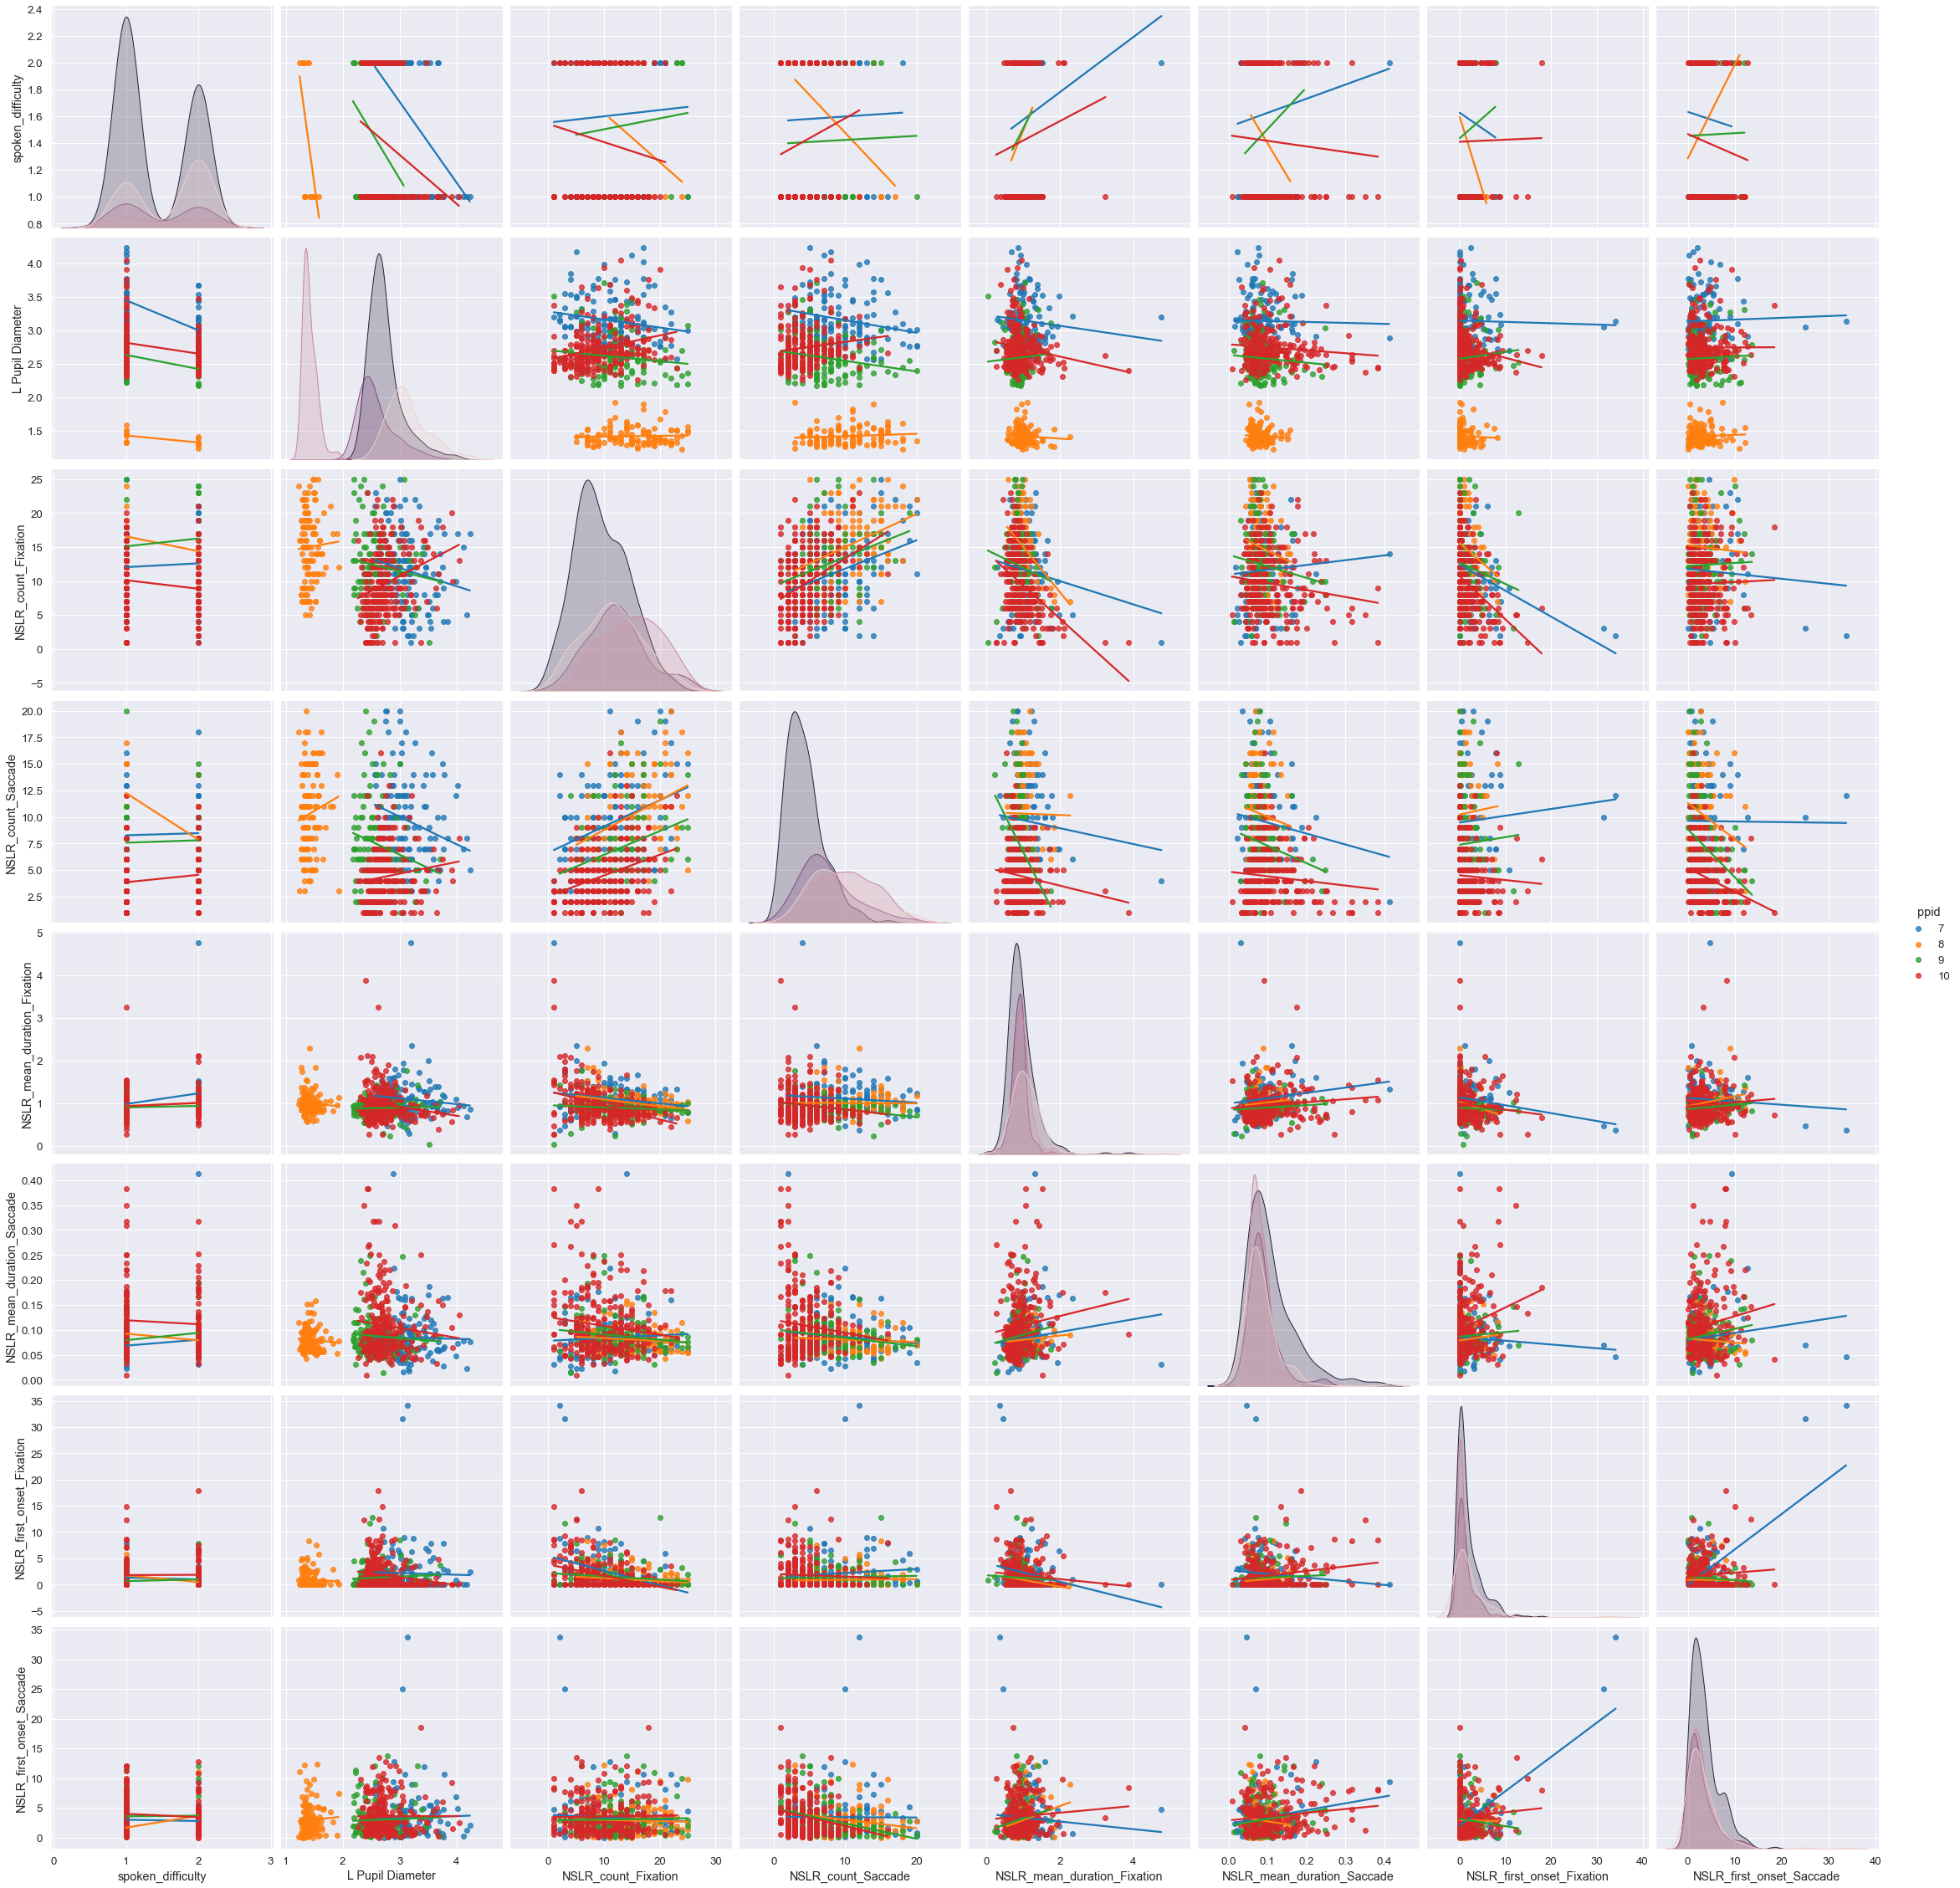

In [145]:
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'easy', 'spoken_difficulty'] = 1
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'hard', 'spoken_difficulty'] = 2
all_dfs_final.loc[all_dfs_final['spoken_difficulty'] == 'unknown', 'spoken_difficulty'] = np.NAN

all_dfs_final['spoken_difficulty'] = all_dfs_final['spoken_difficulty'].astype(float)
#g = sns.pairplot(all_dfs_final[experimental_cols+['ppid_session']], kind="reg", vars=experimental_cols,
#                 diag_kind="kde",height=4, hue="ppid_session", plot_kws=dict(ci=None))

# eye cols
saccade_cols = ['spoken_difficulty', 'density',"NSLR_count_Saccade",'NSLR_mean_duration_Saccade',
           'NSLR_first_onset_Saccade']
#g = sns.pairplot(all_dfs_final[saccade_cols+['ppid_session']], kind="reg", vars=saccade_cols,
#                 diag_kind="kde",height=4, hue="ppid_session", plot_kws=dict(ci=None))

#g = sns.pairplot(all_dfs_final[ecg_cols+['ppid_session']], kind="reg", vars=ecg_cols,
#                 diag_kind="kde",height=4, hue="ppid_session", plot_kws=dict(ci=None))

g = sns.pairplot(all_dfs_final[eye_cols+['ppid']], kind="reg", vars=eye_cols,
                 diag_kind="kde",height=4, hue="ppid", plot_kws=dict(ci=None))

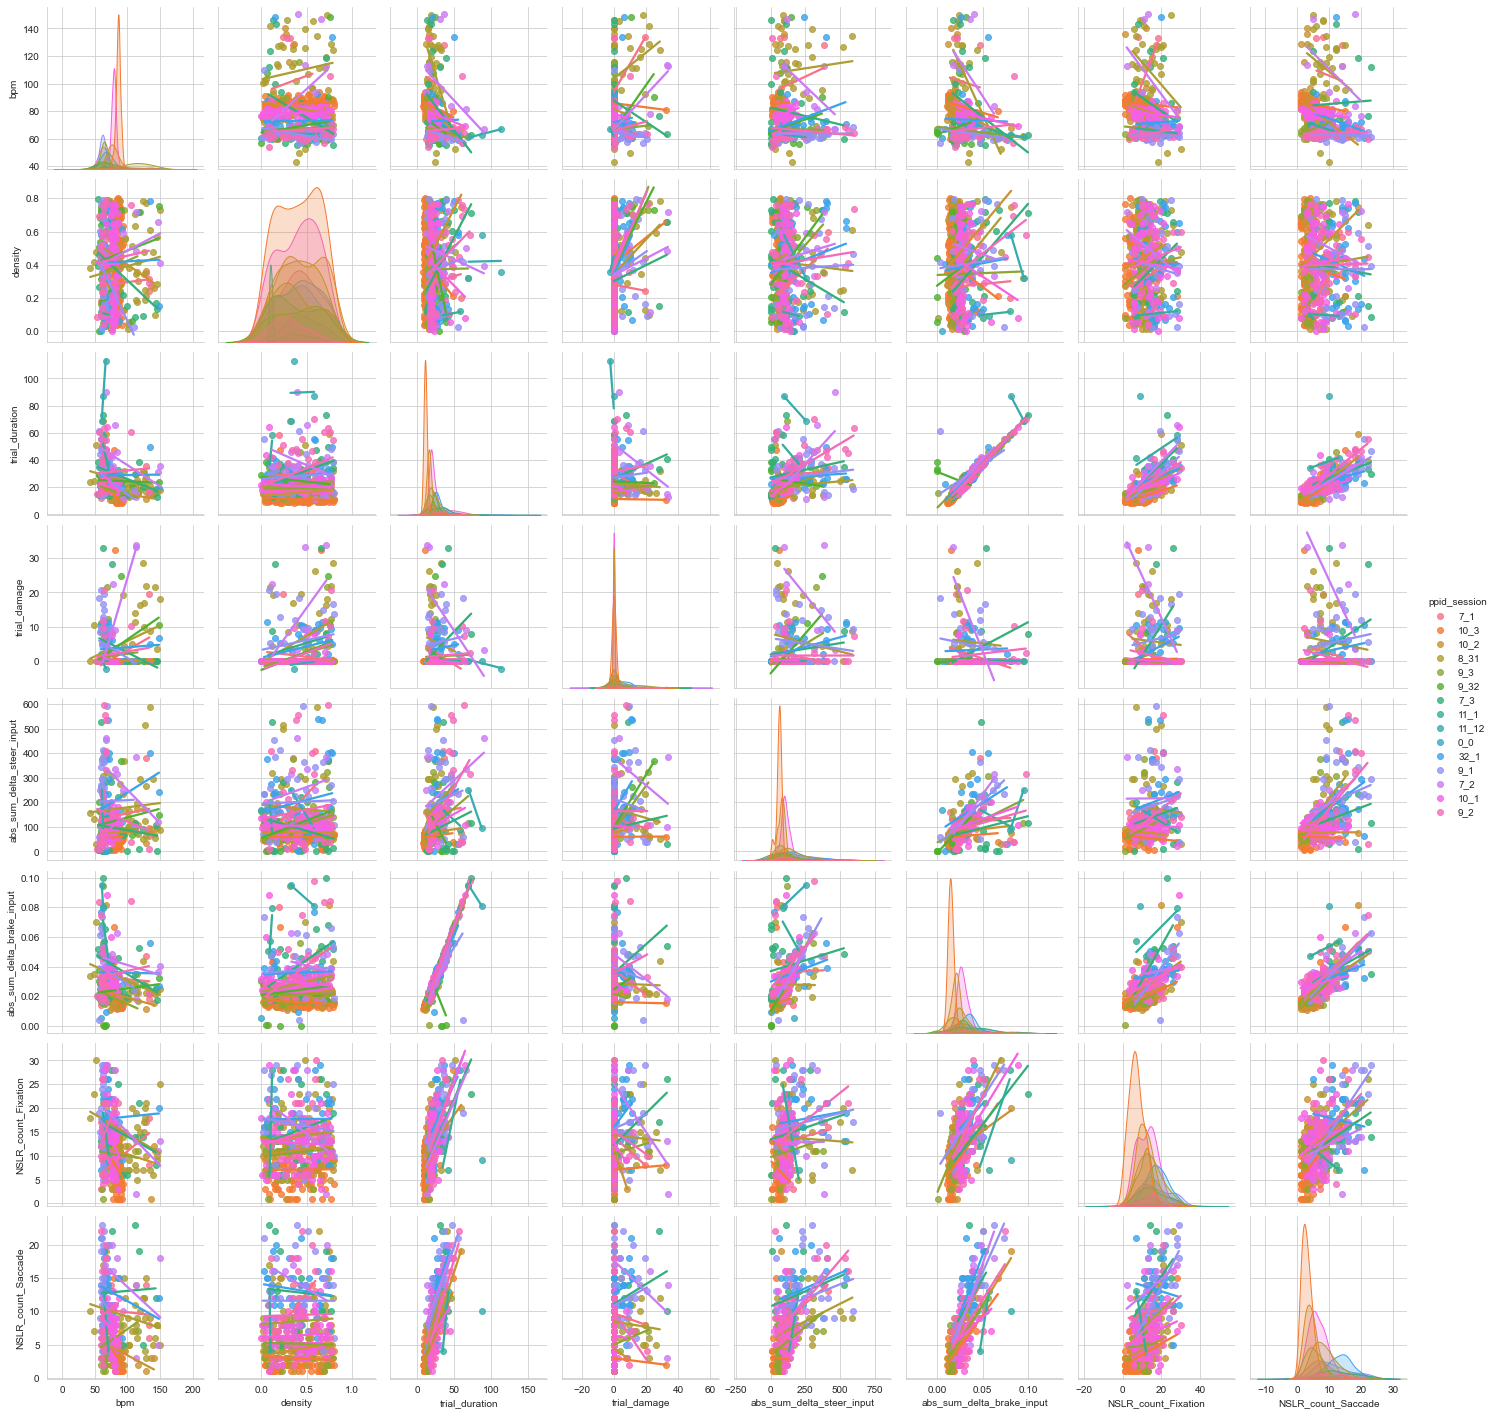

In [58]:
import seaborn as sns
g = sns.pairplot(all_dfs_final, kind="reg", vars=cols_of_interest,
                 diag_kind="kde",height=2.5, hue="ppid_session", plot_kws=dict(ci=None))



In [34]:
all_dfs_final[eye_cols+['ppid_session']].groupby('ppid_session').describe()

Left Pupil Diameter                                          \
                           count      mean       std       min       25%   
ppid_session                                                               
12_1                        58.0  2.333694  0.203869  2.134101  2.214802   
12_2                        96.0  2.277893  0.149183  2.018775  2.192893   
12_3                        82.0  2.498420  0.268362  2.218292  2.344756   
13_1                        16.0  4.071481  0.321963  3.729763  3.801980   
13_2                        54.0  3.889830  0.622078  3.039821  3.371878   
13_3                        77.0  3.412911  0.481540  2.767003  3.042404   
14_1                        33.0  2.548886  0.146249  2.379192  2.465388   
14_2                        60.0  2.463562  0.231358  2.200813  2.325685   
14_3                        69.0  2.387879  0.099145  2.216357  2.321905   
15_1                        34.0  3.010822  0.210486  2.693566  2.837602   
16_1                        64.0  3.671929  0.350142  3.216817  3.375026   
16_2                        71.0  3.167857  0.431286  2.759314  2.928687   
16_3                        90.0  3.140467  0.288760  2.754767  2.916137   
17_1                        44.0  3.034544  0.229830  2.688767  2.862203   
17_2                         0.0       NaN       NaN       NaN       NaN   
17_3                        74.0  2.803523  0.282566  2.275865  2.607857   
18_1                        47.0  2.795292  0.232086  2.428515  2.641883   
18_2                        57.0  2.614579  0.279795  2.290922  2.418746   
18_3                        57.0  2.482419  0.211816  2.209089  2.335087   
19_1                        38.0  3.135036  0.302487  2.809361  2.935990   
19_2                        65.0  2.761247  0.208543  2.425656  2.628610   
19_3                        77.0  2.976904  0.305329  2.590262  2.752798   
20_1                        40.0  2.887528  0.376506  2.498822  2.631262   
20_2                        56.0  2.812225  0.247264  2.539877  2.671670   
20_3                        75.0  3.264239  0.269221  2.996558  3.136015   
21_1                        52.0  2.877810  0.235413  2.507364  2.757222   
21_2                        78.0  2.585524  0.196889  2.258889  2.445285   
21_3                        74.0  2.490428  0.172033  2.122243  2.359491   
22_1                        19.0  3.050229  0.366281  2.514828  2.819628   
23_1                        46.0  4.296165  0.518921  3.500471  3.905457   
23_2                        74.0  3.976579  0.437971  3.342539  3.686095   
23_3                        91.0  4.505216  0.778813  3.542281  3.898211   

                                           NSLR_count_Fixation             \
                   50%       75%       max               count       mean   
ppid_session                                                                
12_1          2.254334  2.357499  3.033393                56.0  11.232143   
12_2          2.234553  2.315083  2.985098                86.0   8.976744   
12_3          2.429804  2.526242  3.877159                81.0   8.641975   
13_1          4.043815  4.135245  4.665541                15.0  10.400000   
13_2          3.843440  4.122191  5.535209                52.0  11.250000   
13_3          3.252189  3.742321  4.733251                73.0   5.986301   
14_1          2.504621  2.566031  3.010122                32.0  10.093750   
14_2          2.421666  2.485743  3.373840                52.0  10.019231   
14_3          2.369281  2.433031  2.686001                69.0   9.086957   
15_1          3.017930  3.141715  3.474700                23.0  14.782609   
16_1          3.587884  3.850941  4.500669                63.0  10.793651   
16_2          3.021539  3.226377  5.124496                70.0   8.471429   
16_3          3.084102  3.249901  4.148039                84.0   5.369048   
17_1          2.982567  3.204436  3.717677                40.0  10.075000   
17_2               NaN       NaN       NaN 

## COE

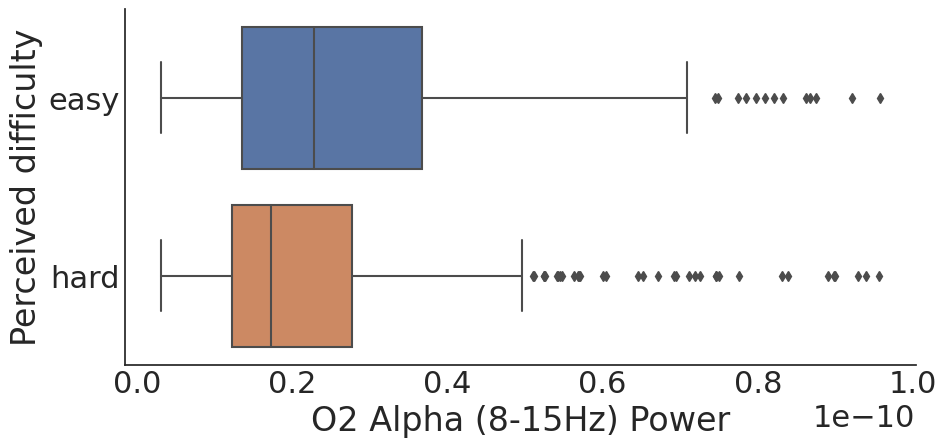

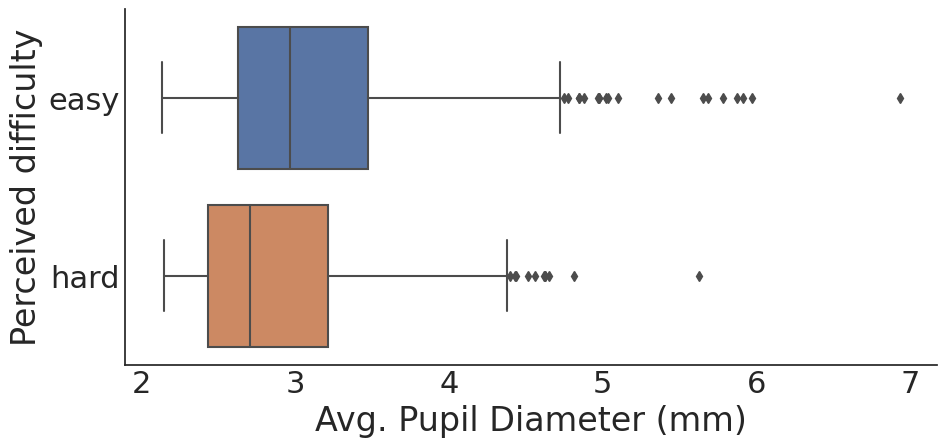

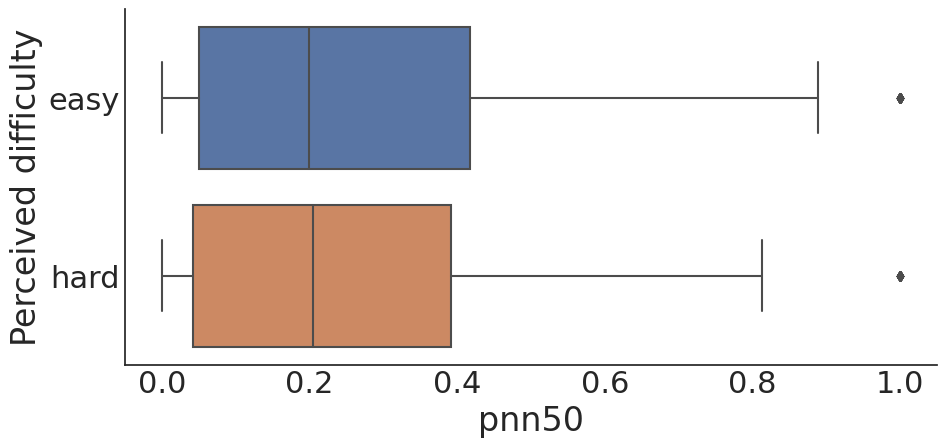

In [82]:
sns.set(font_scale=2)
plt.style.use('seaborn-white')

# some preliminary filters for data viz
coe_eeg_copy = all_dfs_final.copy()
coe_eeg_copy = coe_eeg_copy.loc[coe_eeg_copy['O2_8-15_Hz_Power'] < 1e-10]
g = sns.catplot(data=coe_eeg_copy, y="spoken_difficulty", x="O2_8-15_Hz_Power", kind="box", order=['easy','hard'], aspect=2)
g.set_axis_labels("O2 Alpha (8-15Hz) Power", "Perceived difficulty")
plt.savefig('output/coe_eeg.png', dpi=300)

coe_pupil_copy = all_dfs_final.copy()
g = sns.catplot(data=coe_pupil_copy, y="spoken_difficulty", x="Left Pupil Diameter", kind="box", order=['easy','hard'], aspect=2) # in mm
g.set_axis_labels("Avg. Pupil Diameter (mm)", "Perceived difficulty")
plt.savefig('output/coe_pupil.png', dpi=300)

coe_pnn_copy = all_dfs_final.copy()
g = sns.catplot(data=coe_pnn_copy, y="spoken_difficulty", x="pnn50", kind="box", order=['easy','hard'], aspect=2)
g.set_axis_labels("pnn50", "Perceived difficulty")
plt.savefig('output/coe_pnn.png', dpi=300)